In [1]:
import ROOT
from ROOT import gStyle
#from ROOT import RDataFrame
gStyle.SetOptStat(0)

Welcome to JupyROOT 6.28/00


In [2]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({"axes.grid" : True, "grid.color": "whitesmoke"})
plt.rcParams['axes.axisbelow'] = True

In [3]:
#we load the three as a root dataframe= rdf
#https://root.cern/doc/master/df001__introduction_8py.html
#rdf=ROOT.RDataFrame("Data_R", "/Users/bertabeltran/mist/data/efficiency_test/sec1_double_eff_test_spectra_waves/RAW/SDataR_sec1_double_eff_test_spectra_waves.root")
rdf=ROOT.RDataFrame("Data_R", "/Users/bertabeltran/mist/data/efficiency_test/full_double_eff_test_spectra_waves/RAW/SDataR_full_double_eff_test_spectra_waves.root")

In [4]:
# this tutorial shows how to read the branches into numpy arrays 
#https://root.cern/doc/master/df026__AsNumpyArrays_8py.html
channel = rdf.AsNumpy(columns=["Channel"])
energy = rdf.AsNumpy(columns=["Energy"])
timestamps = rdf.AsNumpy(columns=["Timestamp"])
channel['Channel']

ndarray([0, 0, 0, ..., 0, 0, 1], dtype=object)

Warning in <TFile::Init>: file /Users/bertabeltran/mist/data/efficiency_test/full_double_eff_test_spectra_waves/RAW/SDataR_full_double_eff_test_spectra_waves.root probably not closed, trying to recover
Info in <TFile::Recover>: /Users/bertabeltran/mist/data/efficiency_test/full_double_eff_test_spectra_waves/RAW/SDataR_full_double_eff_test_spectra_waves.root, recovered key TTree:Data_R at address 113568021
Warning in <TFile::Init>: successfully recovered 1 keys


In [5]:
len(energy["Energy"])

408780

In [6]:
len(channel['Channel'])

408780

In [7]:
#Create masks for channels
CH0_mask = channel['Channel'] == 0
CH1_mask = channel['Channel'] == 1

#Get timestamps for each channel (time in picoseconds from the begining of the run)
CH0_timestamps = timestamps["Timestamp"][CH0_mask]
CH1_timestamps = timestamps["Timestamp"][CH1_mask]


#Calculate energy of events on each channel
CH0_energy = energy["Energy"][CH0_mask]
CH1_energy = energy["Energy"][CH1_mask]

#calcuate the time difference between events in chn 0
CH0_time_diff = np.diff(CH0_timestamps)
CH0_time_diff=CH0_time_diff/1e+12 #make it seconds 

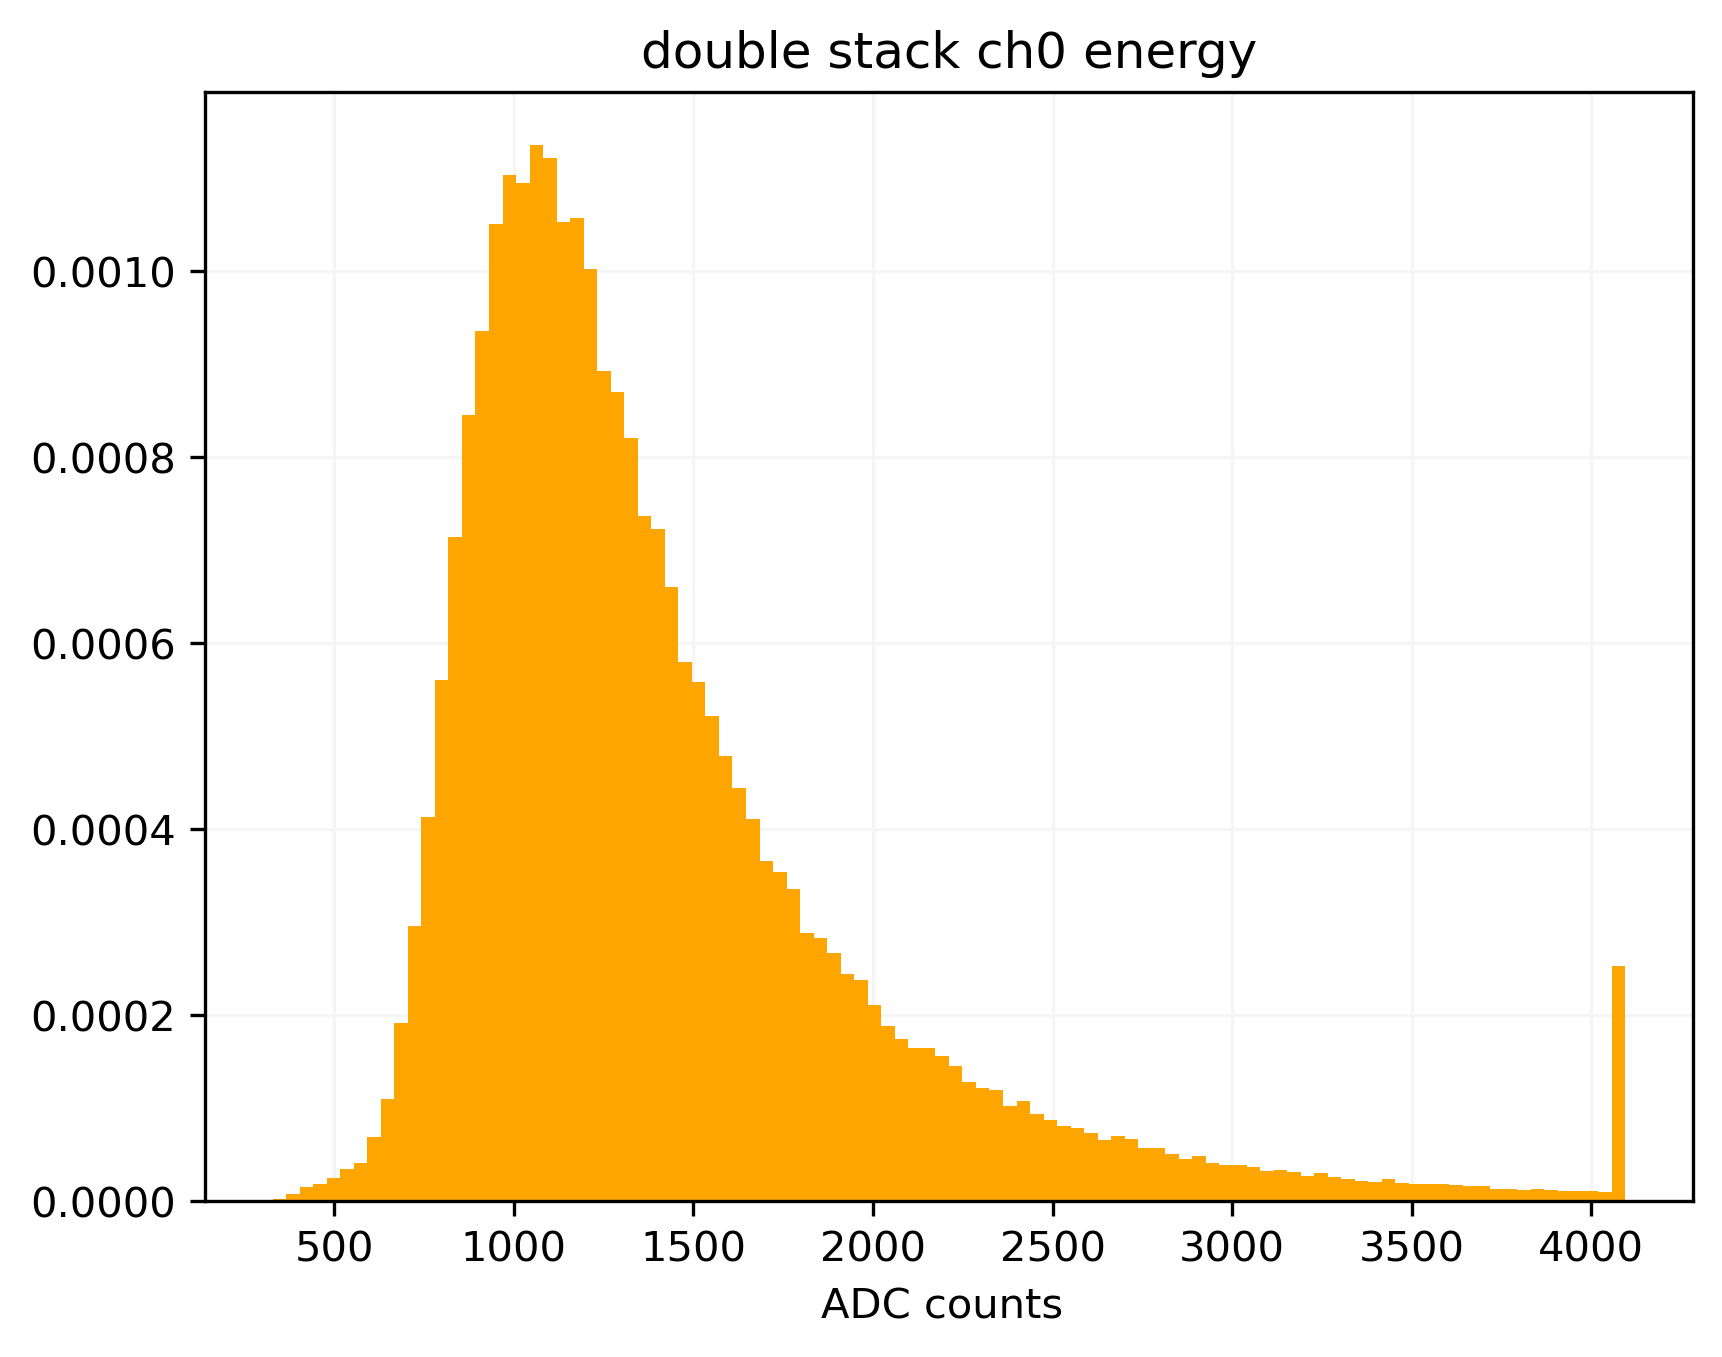

In [8]:
#need to change the type as for some reasong the default one is funny and hist does not like it 
CH0_energy=CH0_energy.astype(np.int64)
plt.hist(CH0_energy, bins = 100, histtype='stepfilled' ,density=True,color ='orange')
#plt.hist(CH0_time_diff, bins = 100,range=(0,4), histtype='stepfilled' ,density=True,color ='orange')
ax=plt.gca()
ax.set_title("double stack ch0 energy")
ax.set_xlabel("ADC counts ")
#plt.yscale('log')


plt.show()

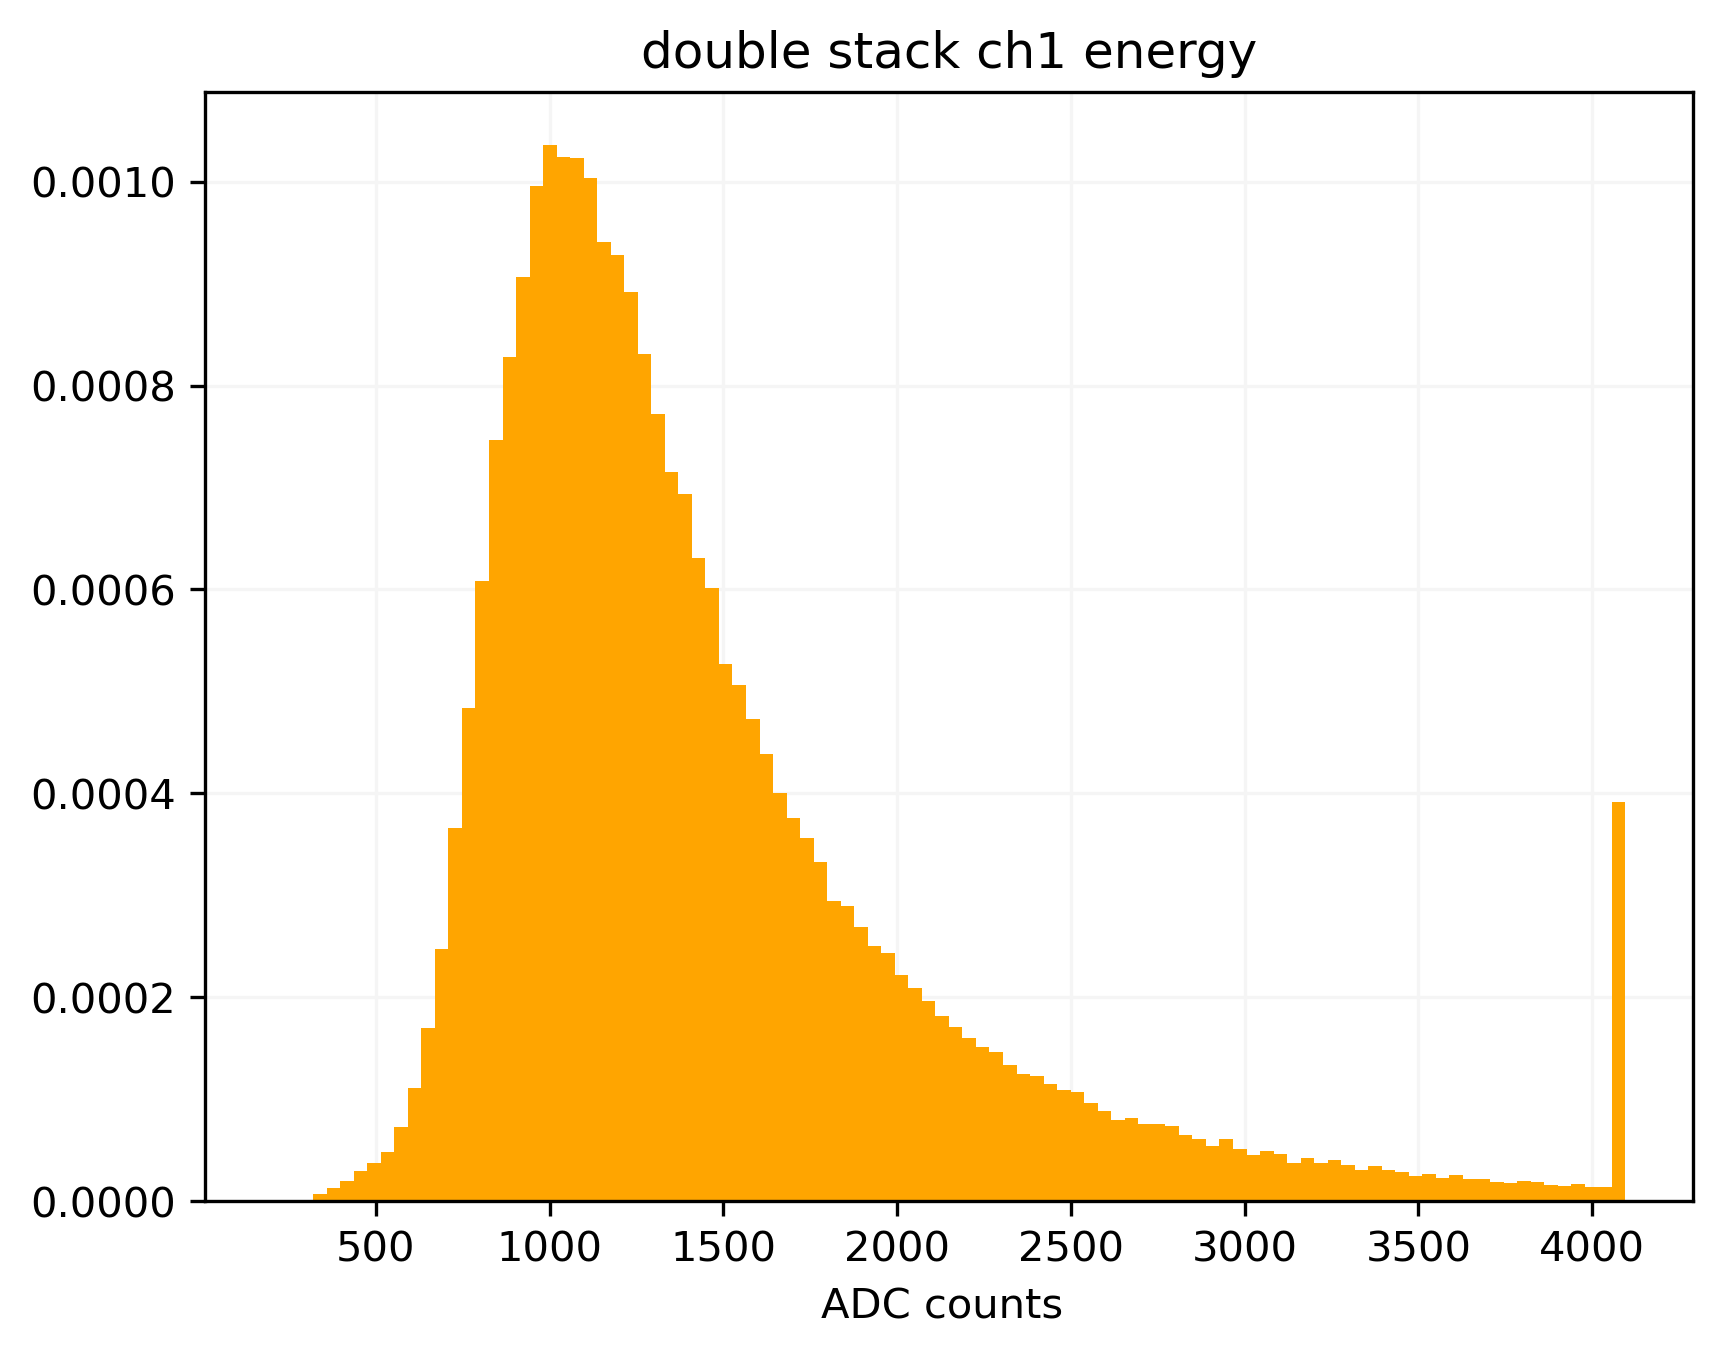

In [9]:
#need to change the type as for some reasong the default one is funny and hist does not like it 
CH1_energy=CH1_energy.astype(np.int64)
plt.hist(CH1_energy, bins = 100, histtype='stepfilled' ,density=True,color ='orange')
#plt.hist(CH0_time_diff, bins = 100,range=(0,4), histtype='stepfilled' ,density=True,color ='orange')
ax=plt.gca()
ax.set_title("double stack ch1 energy")
ax.set_xlabel("ADC counts ")
#plt.yscale('log')


plt.show()

In [10]:
len(CH0_timestamps)

204390

In [11]:
len(CH1_timestamps)

204390

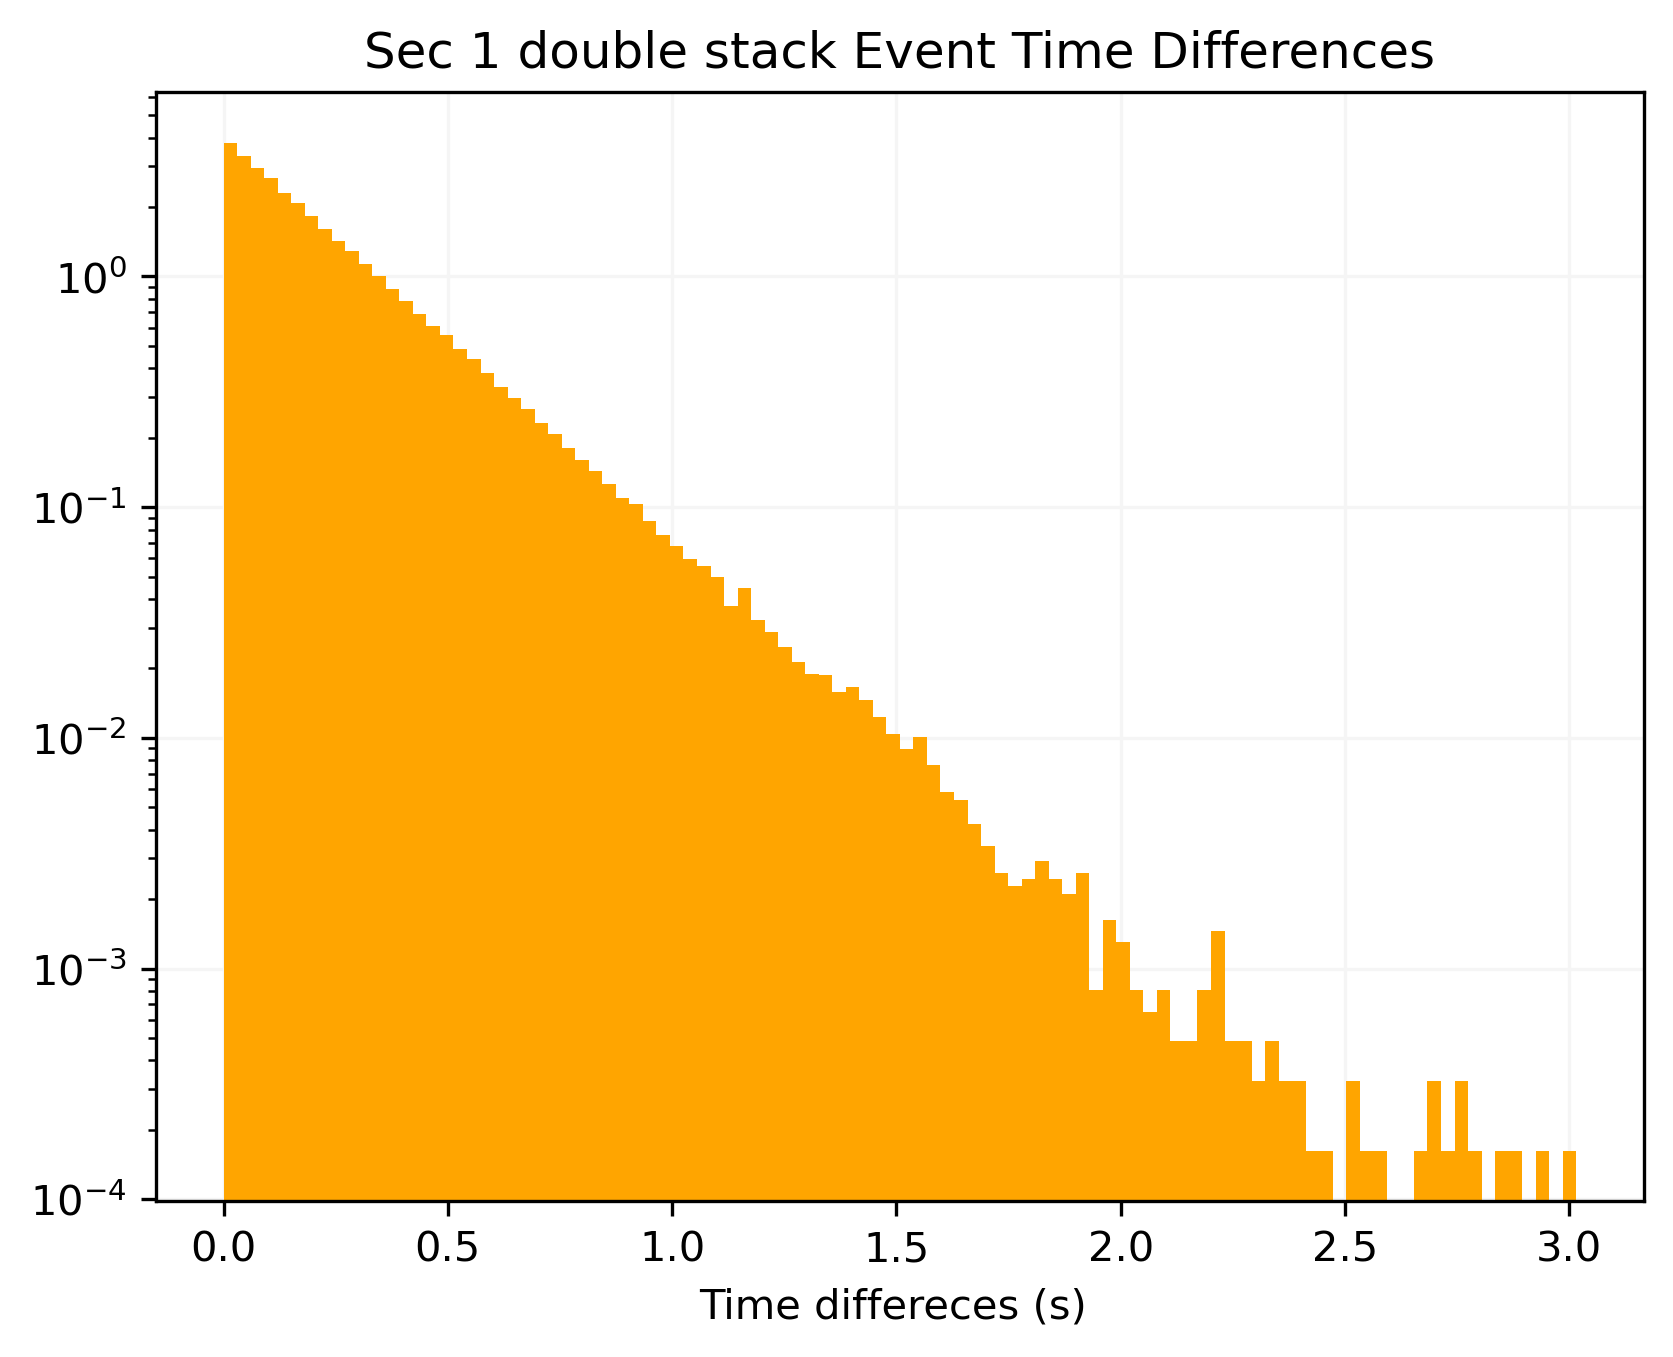

In [12]:
# plot the time differences distribution to see if it looks right 

plt.hist(CH0_time_diff, bins = 100, histtype='stepfilled' ,density=True,color ='orange')
#plt.hist(CH0_time_diff, bins = 100,range=(0,4), histtype='stepfilled' ,density=True,color ='orange')
ax=plt.gca()
ax.set_title("Sec 1 double stack Event Time Differences")
ax.set_xlabel("Time differeces (s) ")
plt.yscale('log')


plt.show()


Expo function coefficients:
[10.11261656 -4.01814401]
Covariance of coefficients:
[[ 1.86336593e-06 -7.50522208e-06]
 [-7.50522208e-06  6.00236716e-05]]
rate err 0.007747494535628647


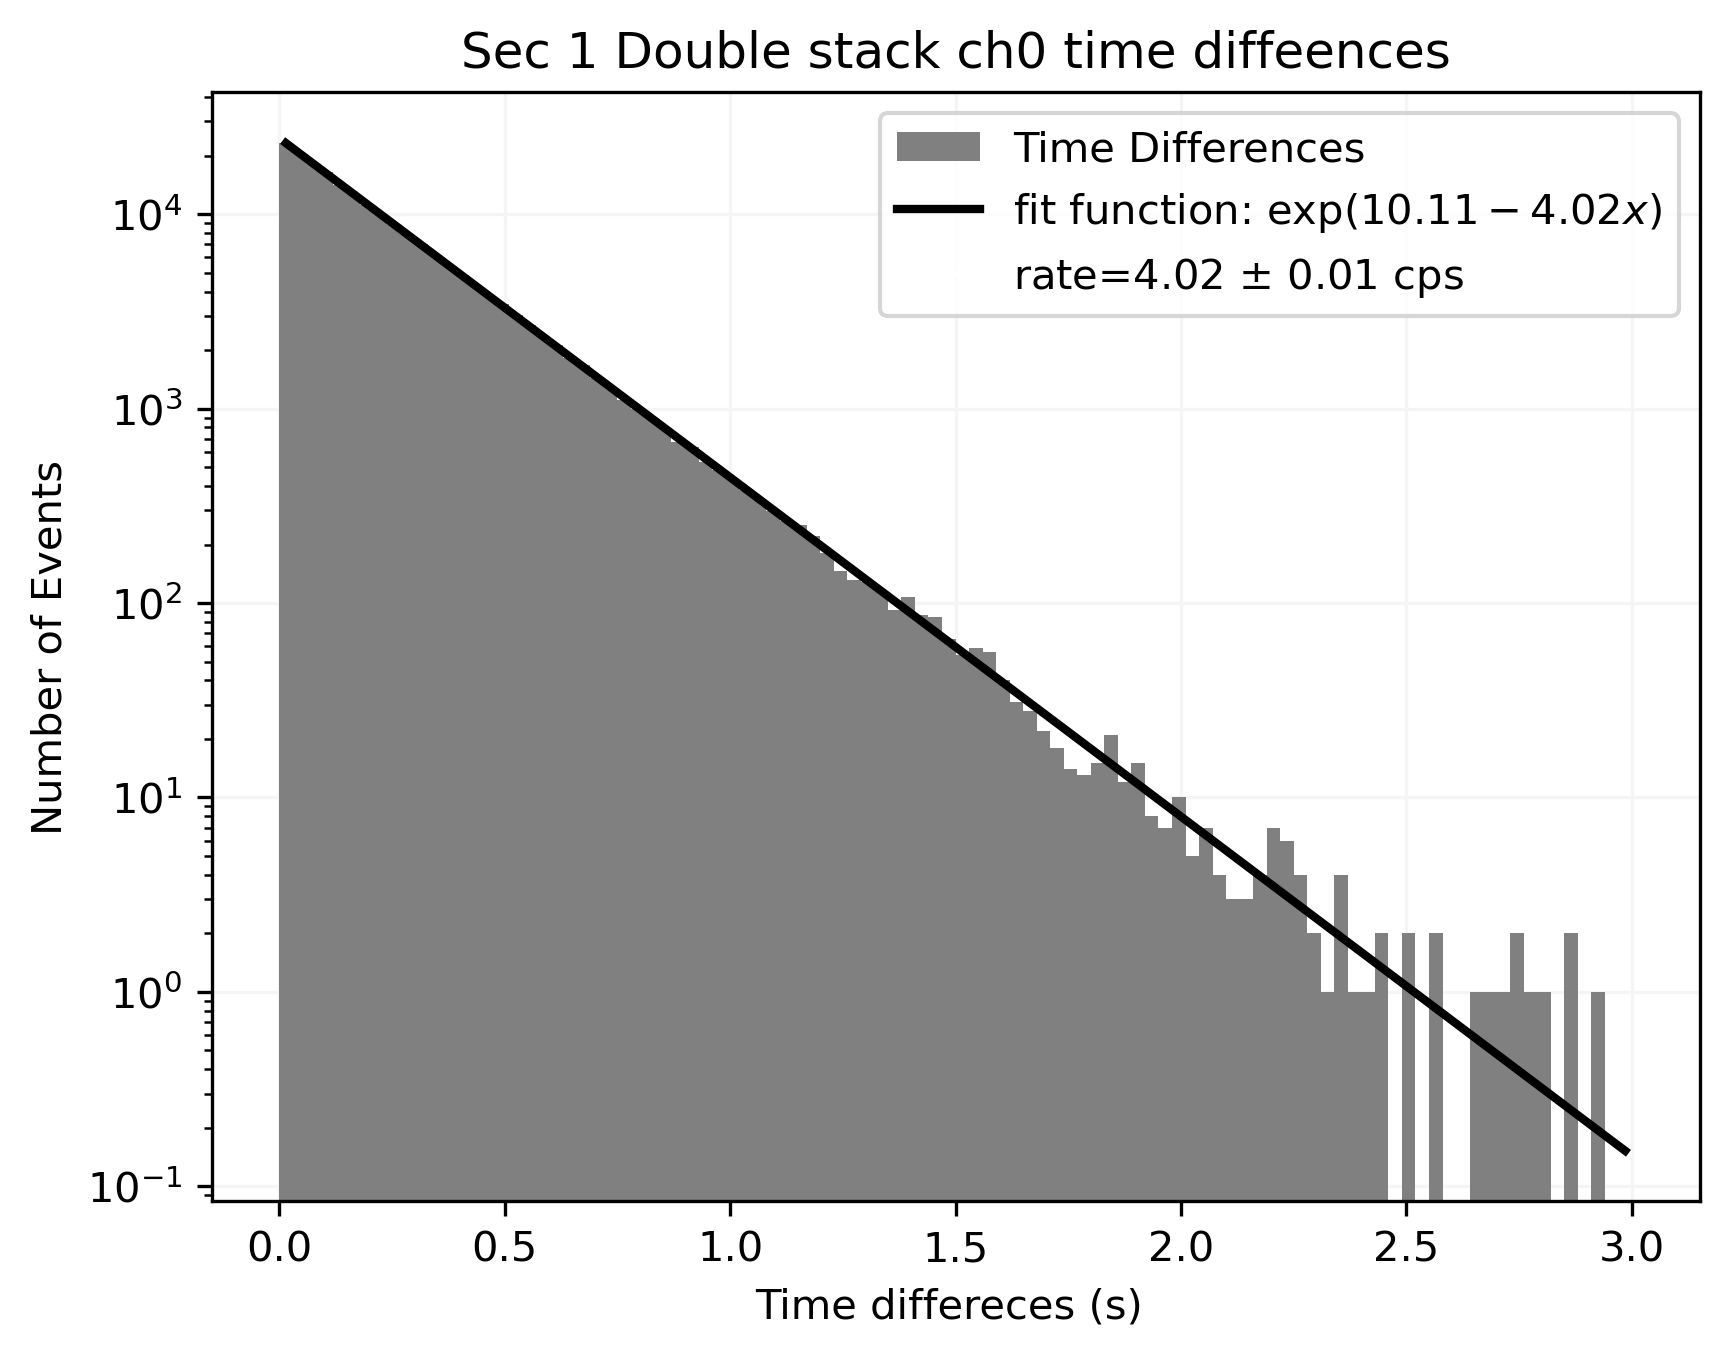

In [14]:
# now I am going to try and fit the time differences plot with curve_fit

import numpy as np
from scipy.optimize import curve_fit
#firts I define the exponential fucntion that I will be fitting 
def expo(x, a, b):
    return  np.exp(a+(b*x))

#here I caculate the bin centers for the fit               
def bincenters(bins):
    return (bins[1:] + bins[:-1]) / 2
                   
# define the histogram that I will be fitting to and return the bin contents and the bid edeges    
bin_cont, bin_edges, patches = plt.hist(CH0_time_diff, bins = 100,range=(0,3), histtype='stepfilled' , color ='gray',label ="Time Differences")
                   
# here I do the fit a return the fit values     
param, param_cov = curve_fit(expo, bincenters(bin_edges),bin_cont)
                   
# print the values     
print("Expo function coefficients:")
print(param)
print("Covariance of coefficients:")
print(param_cov)
# To compute one standard deviation errors on the parameters we need to use 
perr = np.sqrt(np.diag(param_cov))
print ("rate err", perr[1])

# now I also want to draw the fitted function on top of the histogram 
fit_func= expo(bincenters(bin_edges),param[0] ,param[1] )
plt.plot(bincenters(bin_edges), fit_func, 'black', linewidth=2, label ="fit function: exp$({:.2f} {:.2f}x)$".format(param[0] ,param[1]))       

#fit_eq= "exp$({:.2f} {:.2f}x)$".format(param[0] ,param[1])

ax=plt.gca()
#ax.text(1, 1000, fit_eq, fontsize=15)
#ax.text(1.3, 500, "rate={:.2f} $\\pm$ {:.2f} cps".format(abs(param[1]), perr[1]), fontsize=15)

ax.plot([],[],label="rate={:.2f} $\\pm$ {:.2f} cps".format(abs(param[1]), perr[1]), color='w')
plt.legend()
plt.yscale('log')
ax.set_title("Sec 1 Double stack ch0 time diffeences")
ax.set_xlabel("Time differeces (s) ")
ax.set_ylabel('Number of Events')
plt.show()

In [15]:
# caculate the event rate for chan 0 by looking at the rate plot 
# first convert the time stamps to seconds 
CH0_timestamps_sec=CH0_timestamps/1e+12
#now I floor this array to see only seconds 
rate=np.floor(CH0_timestamps_sec)
rate

ndarray([    0.,     0.,     0., ..., 50862., 50862., 50863.])

Text(0.5, 0, 'Seconds from the begining of the run')

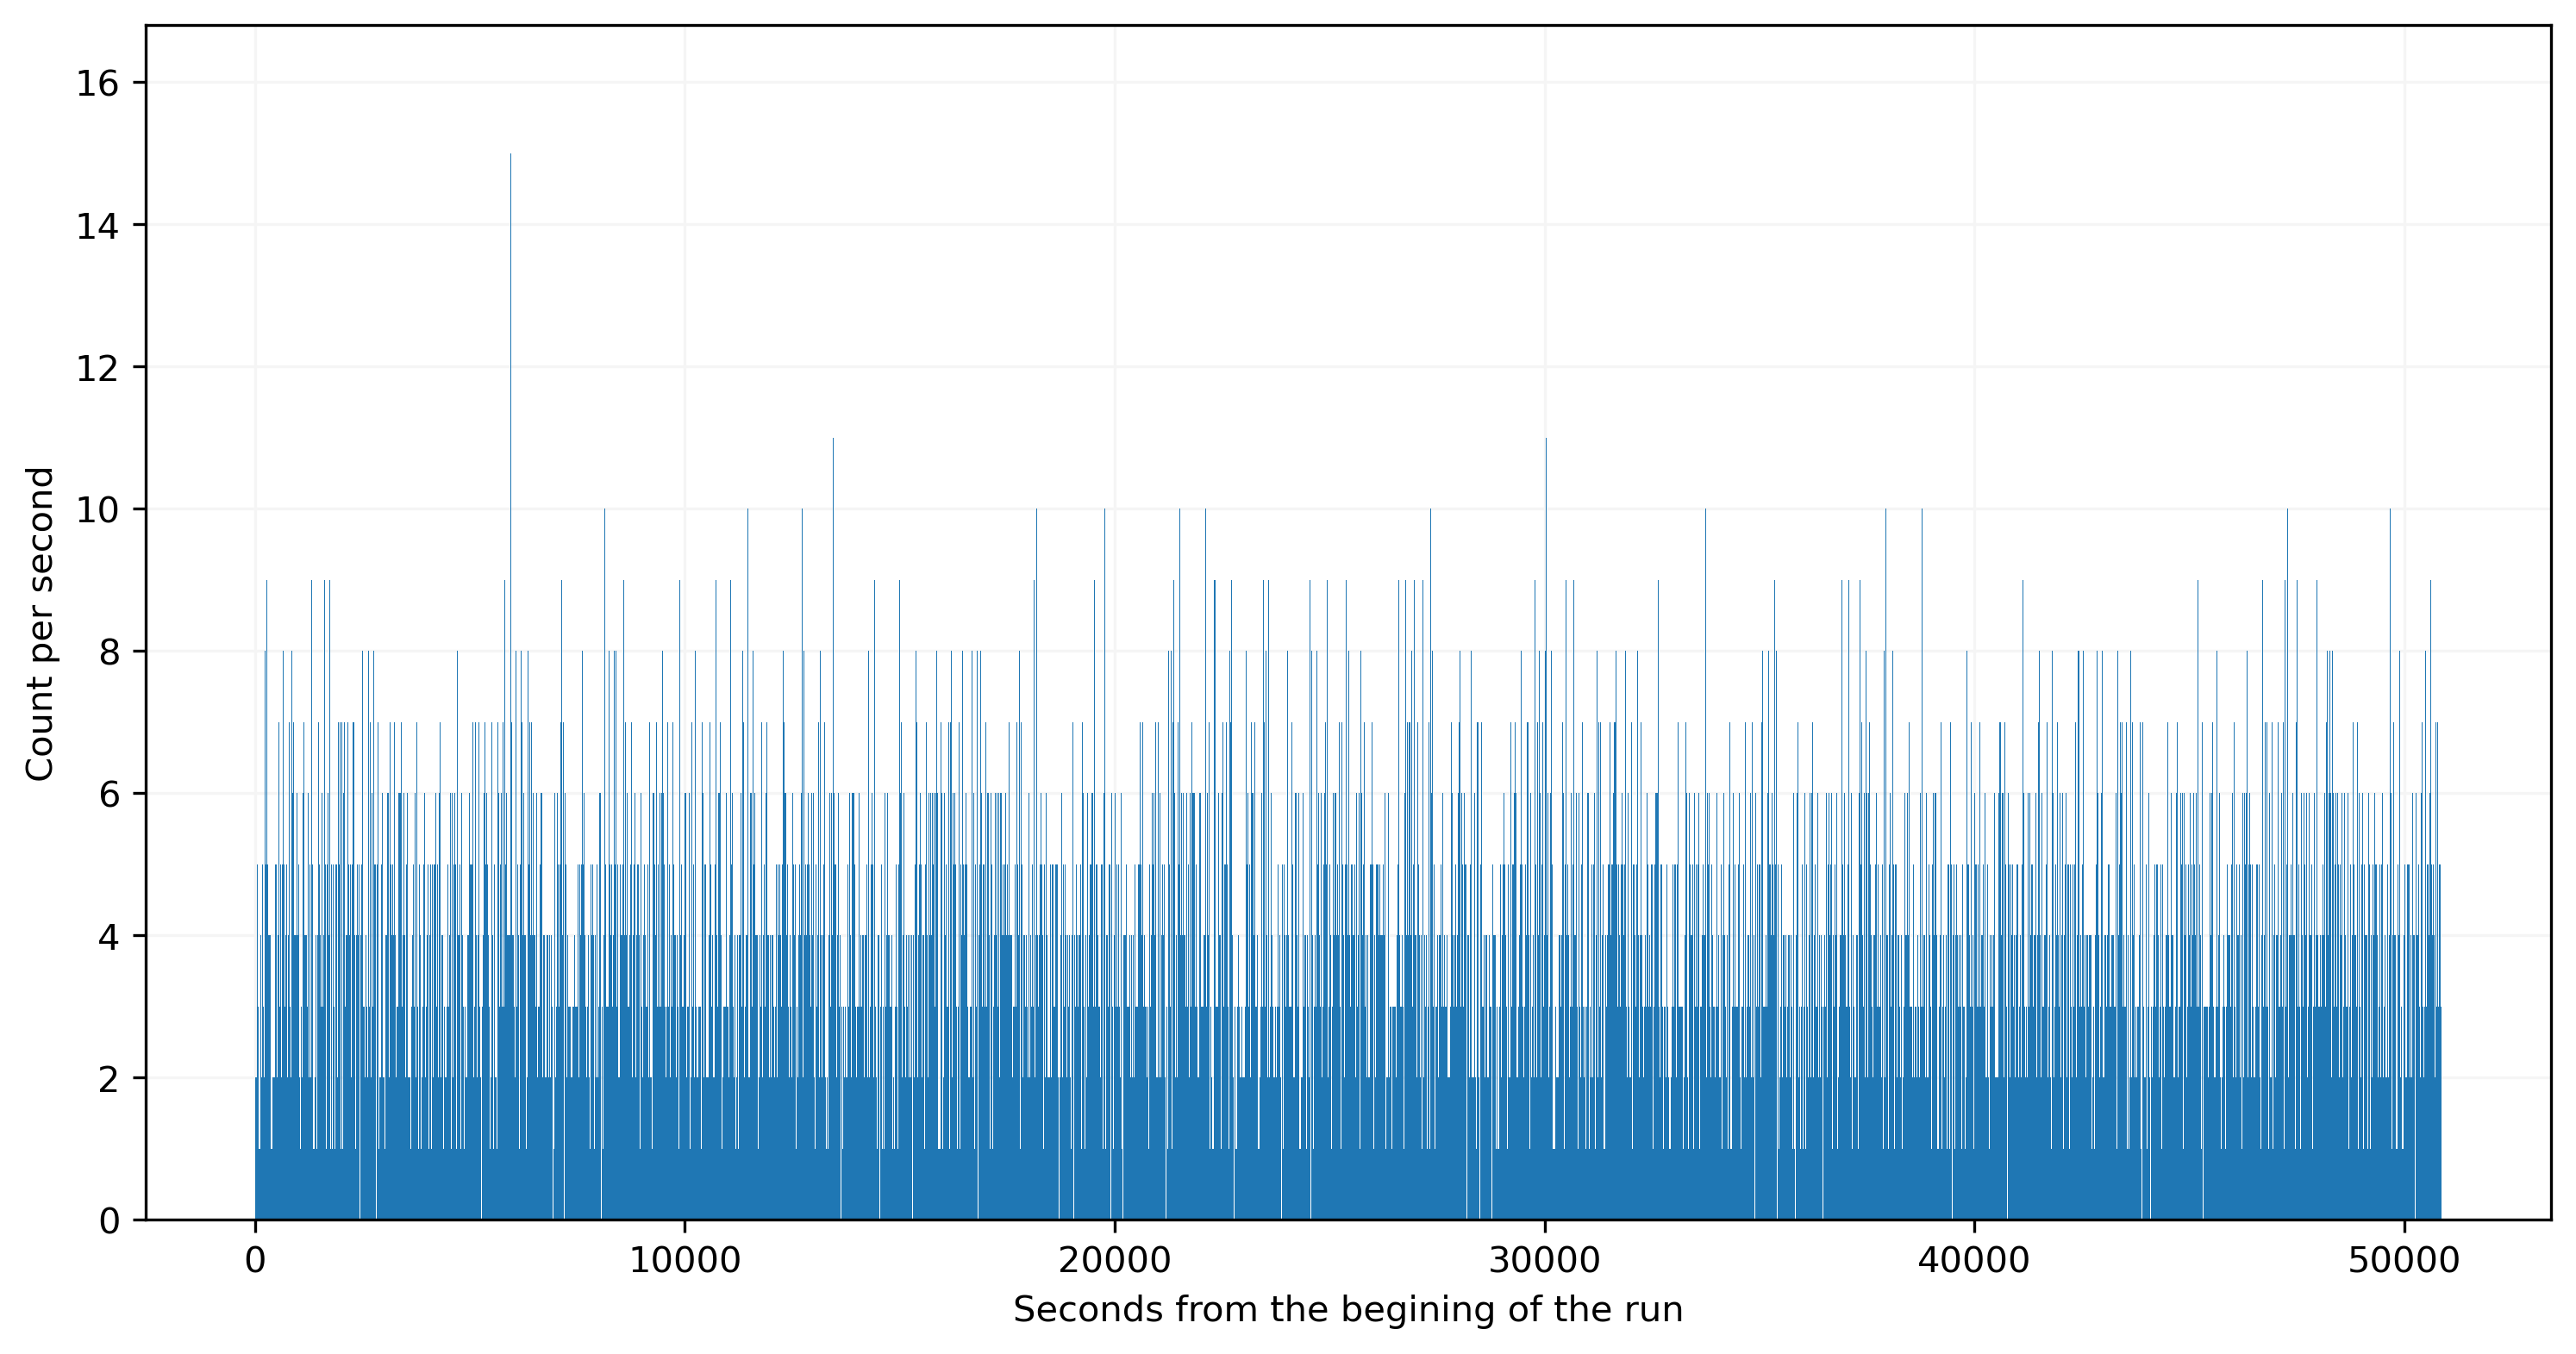

In [51]:
fig, ax = plt.subplots(figsize=(12,6))
bin_contents, bin_edges, patches =plt.hist(rate,bins = 50863, histtype='bar')
#bin_contents, bin_edges, patches =plt.hist(rate, bins = 6832,range=(0,6831))
#bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
ax = plt.gca()
ax.set_ylabel("Count per second")
ax.set_xlabel("Seconds from the begining of the run")
#ax.legend(labels="rate={:.2f} $\\pm$ {:.2f} cps".format(np.mean(bin_contents),np.std(bin_contents)))

(array([1.80484832e-02, 7.27051098e-02, 1.44191259e-01, 1.94719148e-01,
        1.95308967e-01, 1.58366593e-01, 1.04653678e-01, 5.79989383e-02,
        3.22238169e-02, 1.39983878e-02, 4.83652164e-03, 1.94640505e-03,
        6.09480369e-04, 2.55588542e-04, 5.89819712e-05, 7.86426282e-05]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16.]),
 <BarContainer object of 16 artists>)

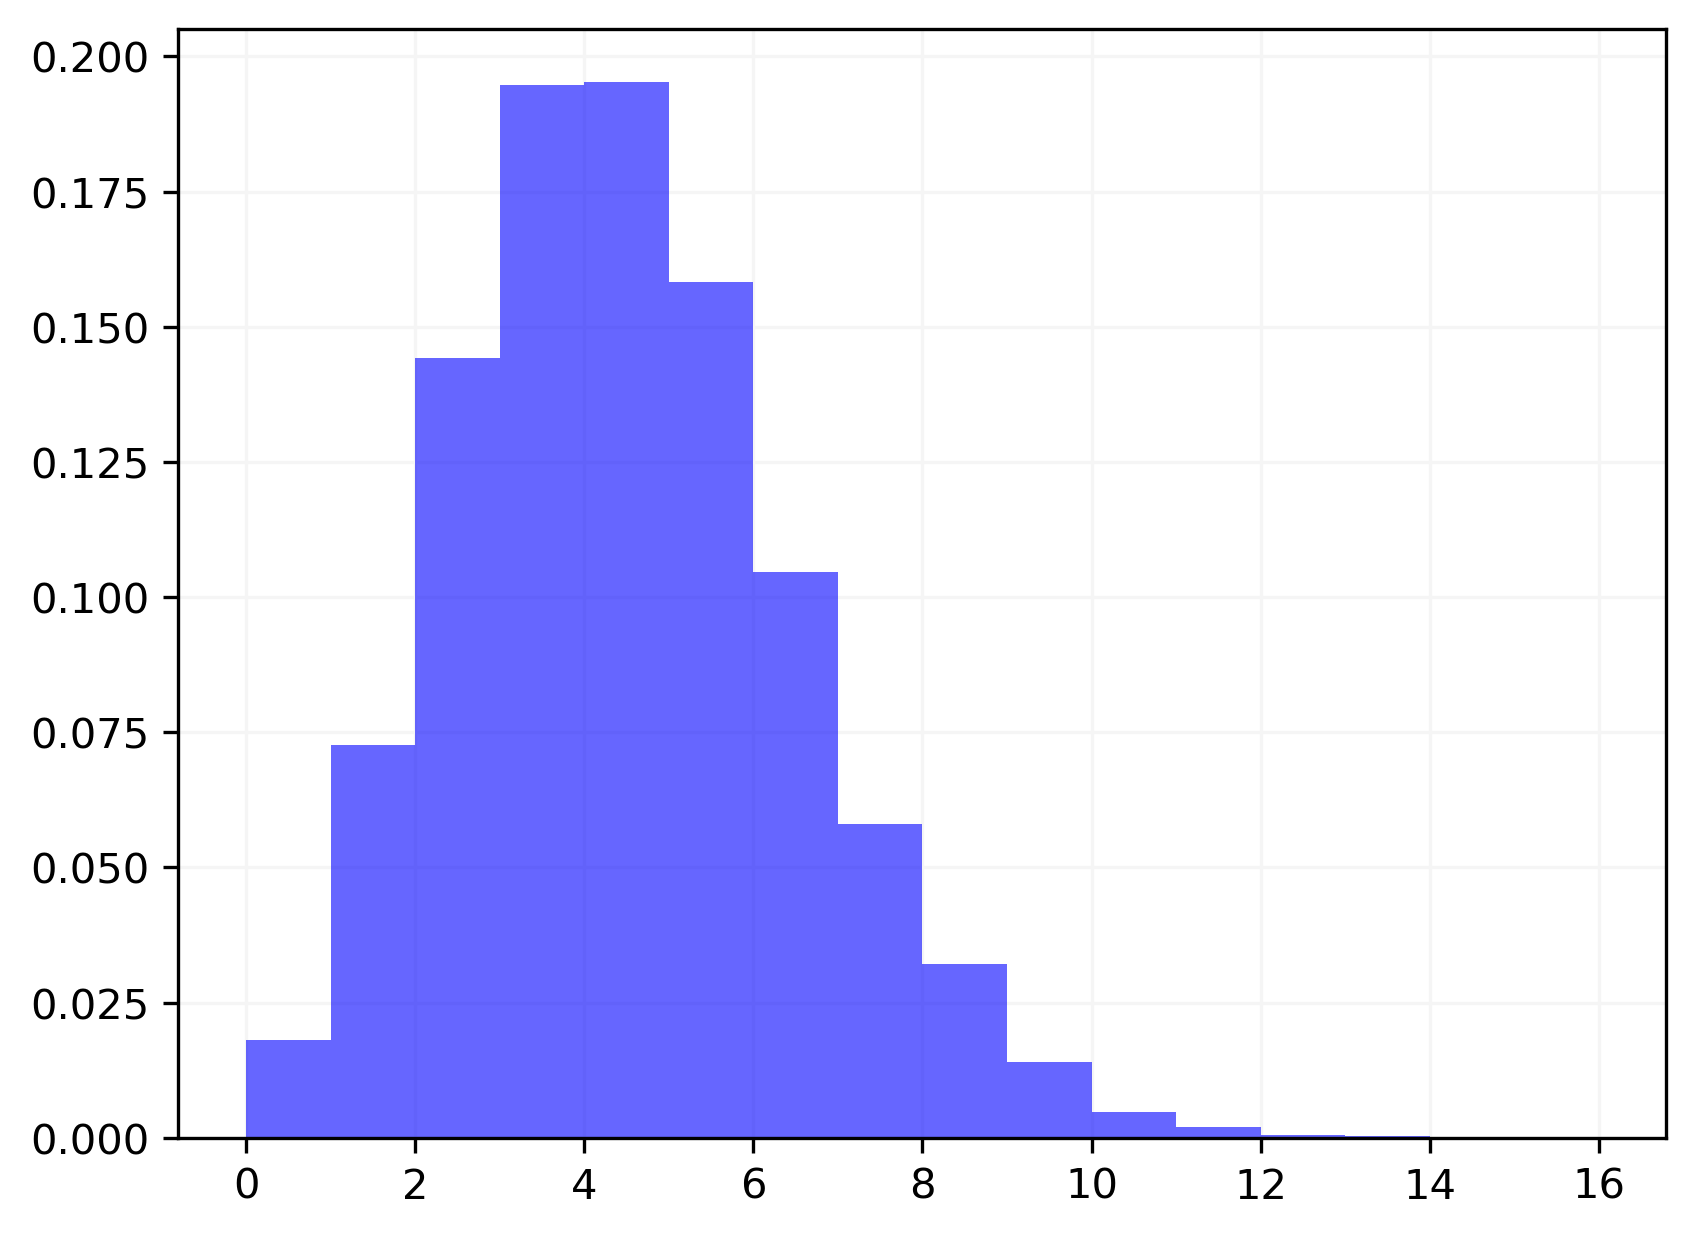

In [52]:
plt.hist(bin_contents, bins=16, density=True, alpha=0.6, color='b')

In [18]:
np.mean(bin_contents)

4.018441696321491

In [19]:
bin_edges

array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 5.0861e+04, 5.0862e+04,
       5.0863e+04])

In [49]:
np.std(bin_contents)

20.121692126453986

In [20]:
#now we want this same plot in counts per minute 
CH0_timestamps_min=CH0_timestamps_sec/60.
CH0_timestamps_min

ndarray([1.65272340e-03, 1.31954034e-02, 1.51461174e-02, ...,
         8.47707335e+02, 8.47713962e+02, 8.47717555e+02])

In [21]:
rate_min_0=np.floor(CH0_timestamps_min)
rate_min_0

ndarray([  0.,   0.,   0., ..., 847., 847., 847.])

Text(0.5, 0, 'Minutes from the begining of the run')

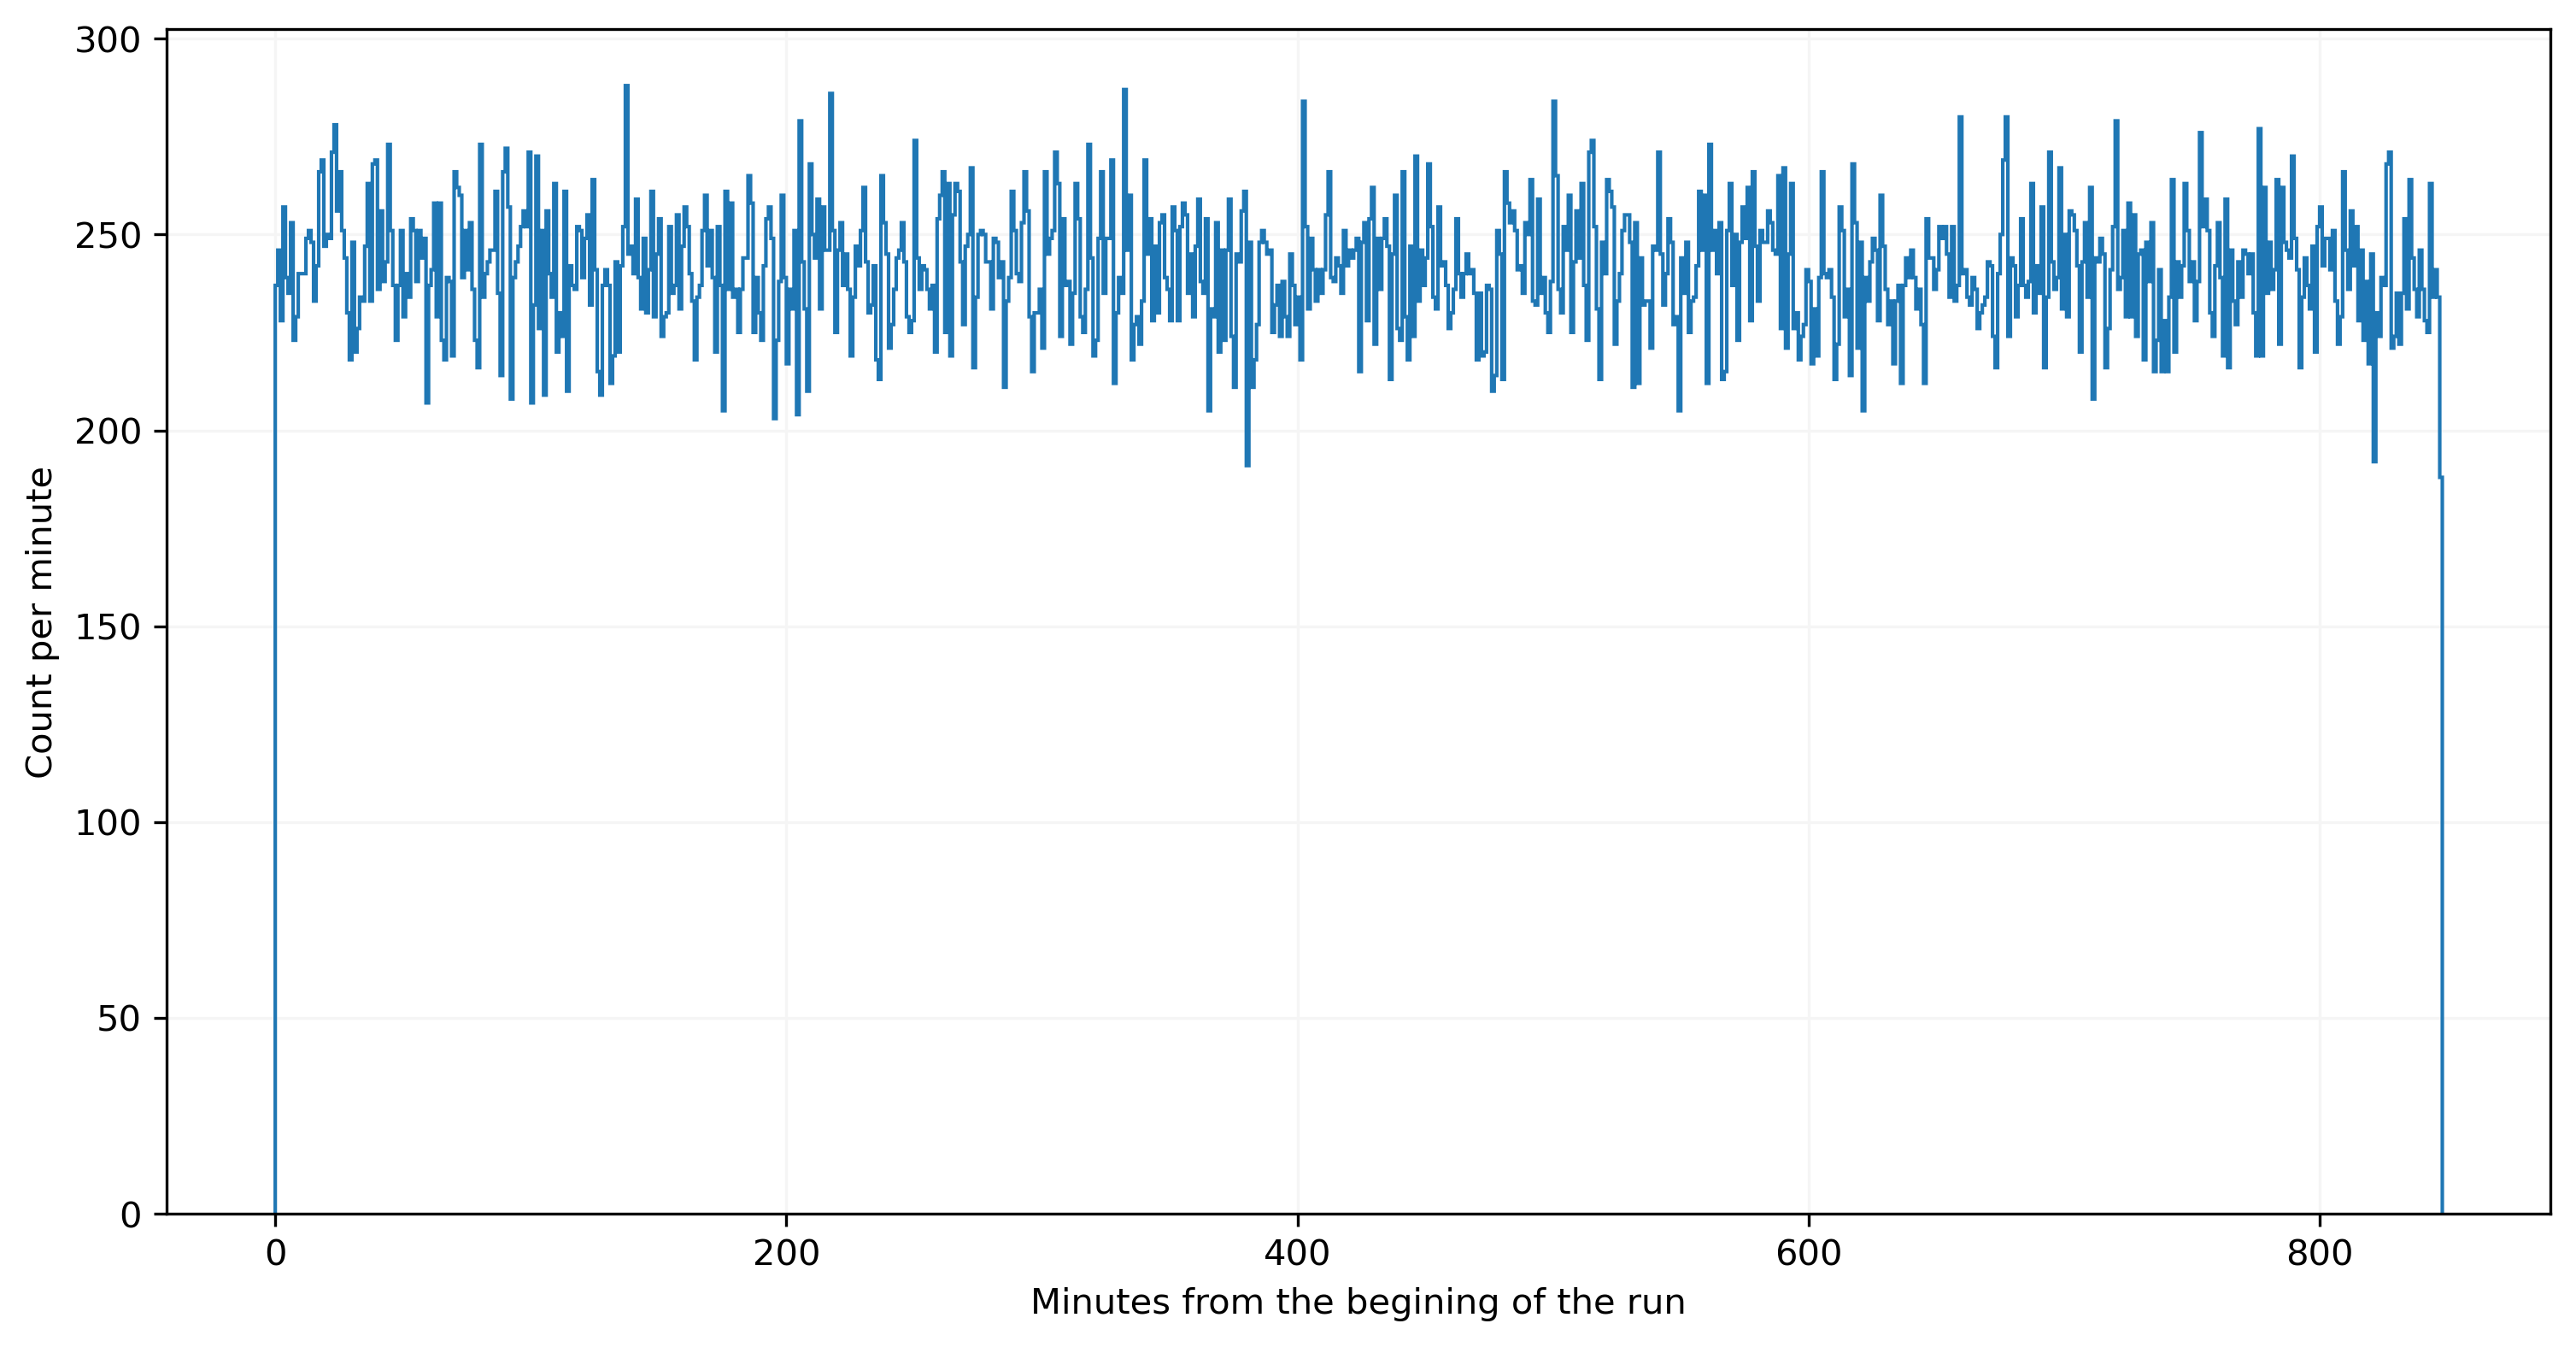

In [69]:
fig, ax = plt.subplots(figsize=(12,6))
bin_contents, bin_edges, patches =plt.hist(rate_min_0,bins = 848, range=(0,848), histtype='step')
#bin_contents, bin_edges, patches =plt.hist(rate, bins = 6832,range=(0,6831))
#bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
ax = plt.gca()
ax.set_ylabel("Count per minute")
ax.set_xlabel("Minutes from the begining of the run")
#ax.set_ylim(150, 300)

In [70]:
bin_edges

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [66]:
bin_contents[846]

422.0

In [25]:
import uproot
#Open triple ROOT file 
file_path_3 = "/Users/bertabeltran/mist/data/efficiency_test/full_triple_eff_test_spectra_waves/RAW/SDataR_full_triple_eff_test_spectra_waves.root"
file3=uproot.open(file_path_3)
tree3=file3["Data_R"]
print(tree3.keys())

#Load data for channels and timestamps
#timestamps = tree["Timestamp"].array(library = "np")*10**(-3) #Convert picoseconds to nano
timestamps3 = tree3["Timestamp"].array(library = "np") # picoseconds
channel3 = tree3["Channel"].array(library = "np")
energy3 = tree3["Energy"].array(library = "np")
flags3 = tree3["Flags"].array(library = "np")

['Channel', 'Timestamp', 'Board', 'Energy', 'EnergyShort', 'Flags', 'Probe', 'Samples']


In [26]:
#Create masks for channels
CH2_mask = channel3 == 2


#Get timestamps for each channel (time in picoseconds from the begining of the run)
CH2_timestamps = timestamps3[CH2_mask]


#Calculate energy of events on each channel
CH2_energy = energy3[CH2_mask]


#calcuate the time difference between events in chn 0
CH2_time_diff = np.diff(CH2_timestamps)
CH2_time_diff_sec=CH2_time_diff/1e+12 #make it seconds 
CH2_timestamps

array([     339797942624,     1094431219249,     1691929500624, ...,
       17995877774817499, 17996705967702374, 17996722918226000],
      dtype=uint64)

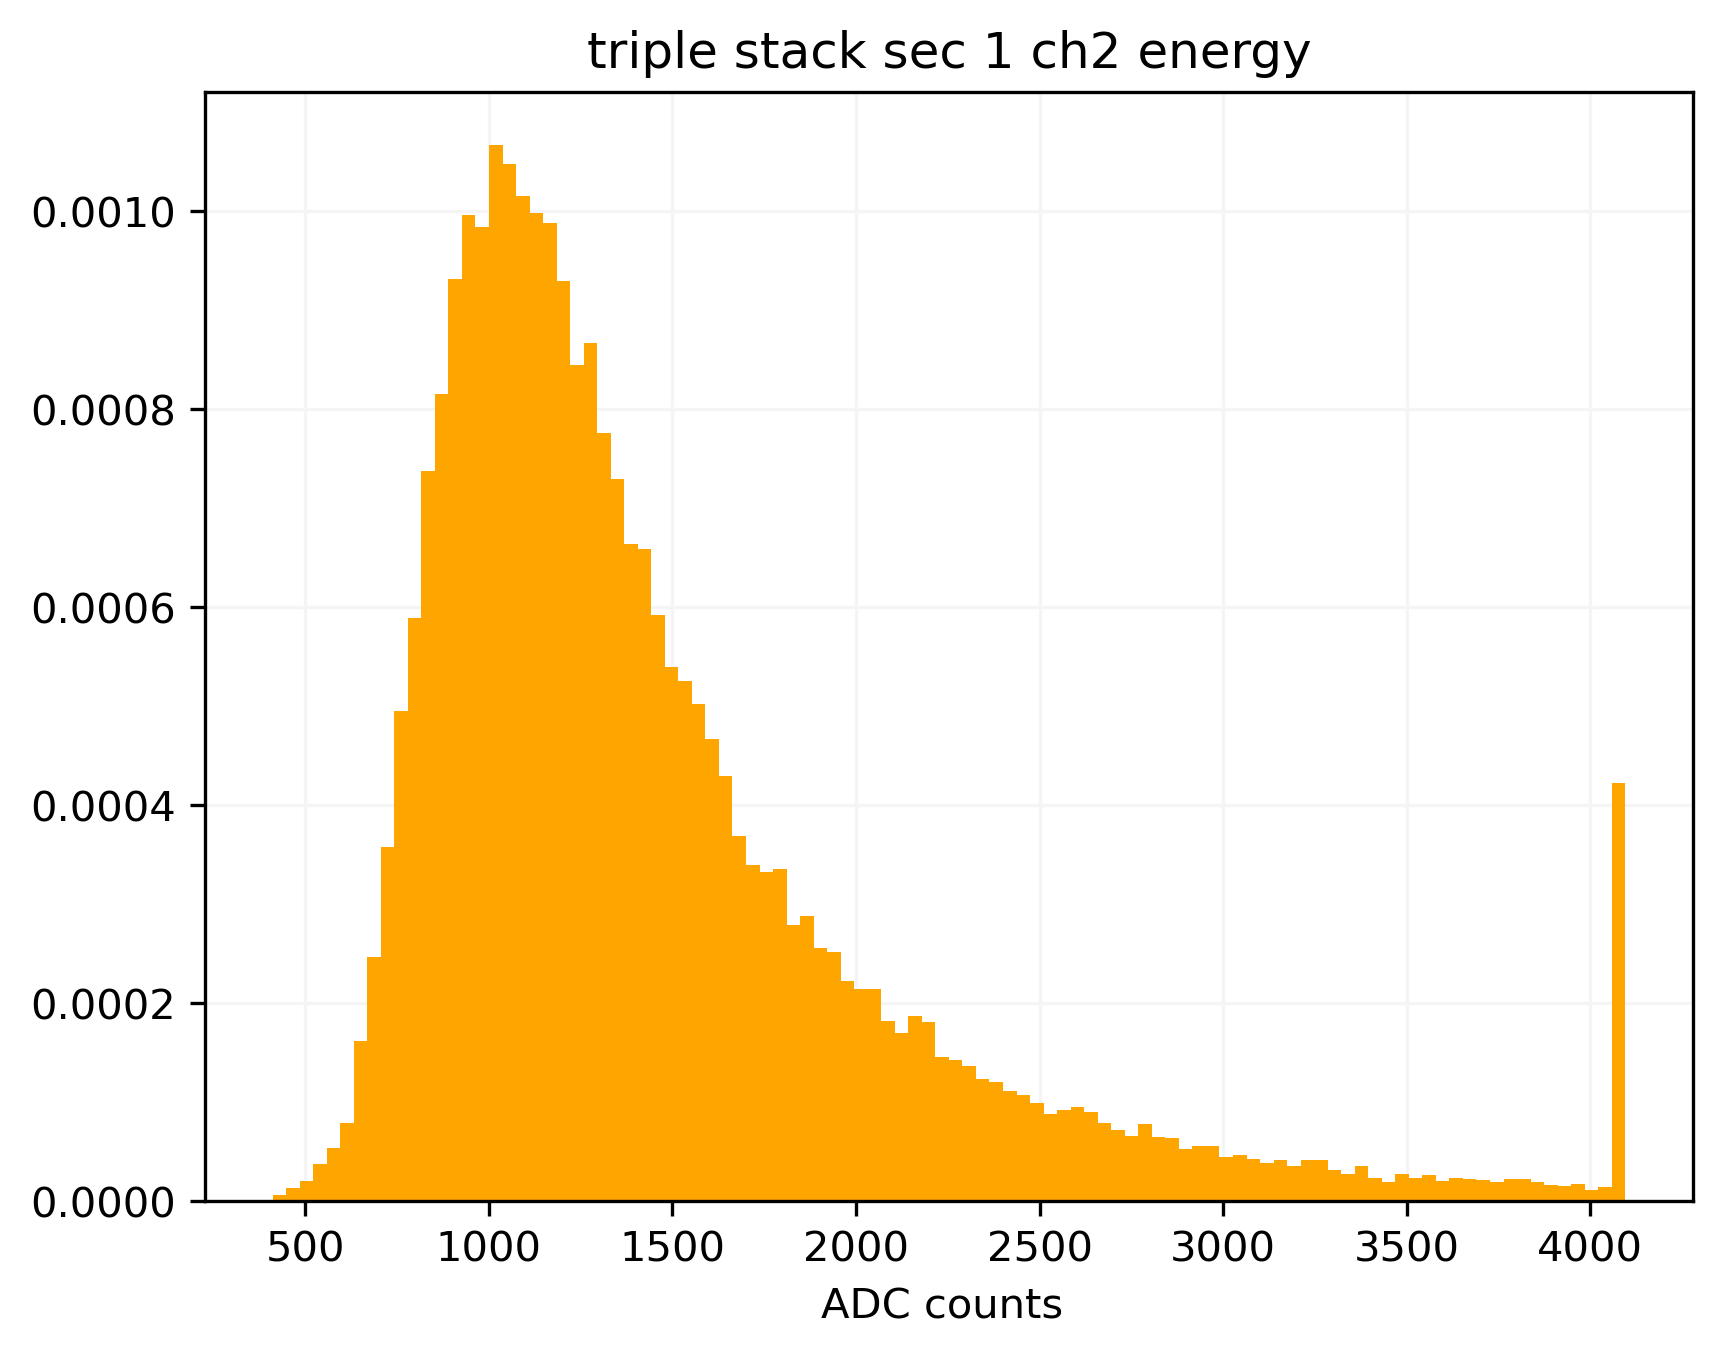

In [27]:
#need to change the type as for some reasong the default one is funny and hist does not like it 
#CH2_energy=CH2_energy.astype(np.int64)
plt.hist(CH2_energy, bins = 100, histtype='stepfilled' ,density=True,color ='orange')
#plt.hist(CH0_time_diff, bins = 100,range=(0,4), histtype='stepfilled' ,density=True,color ='orange')
ax=plt.gca()
ax.set_title("triple stack sec 1 ch2 energy")
ax.set_xlabel("ADC counts ")
#plt.yscale('log')


plt.show()

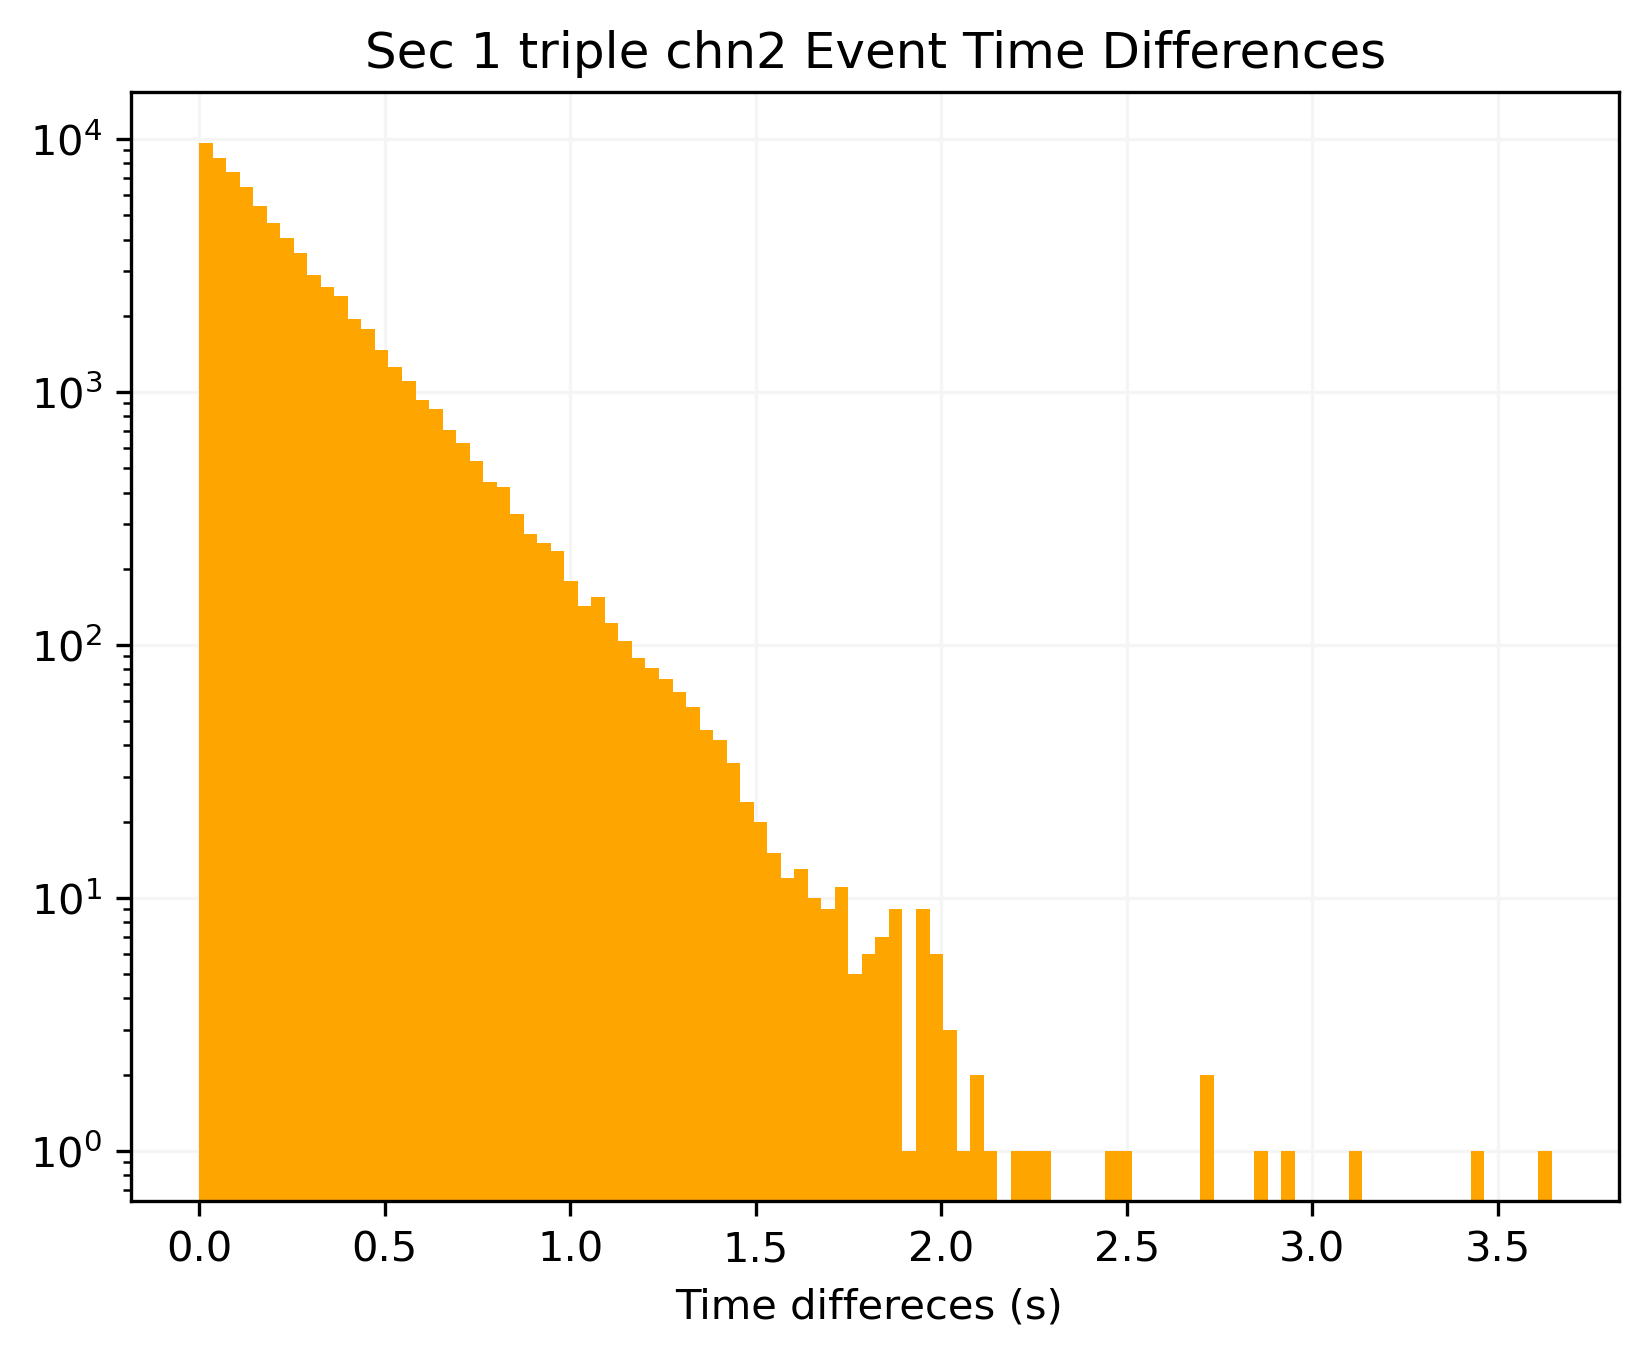

In [28]:
# plot the time differences distribution to see if it looks right 

plt.hist(CH2_time_diff_sec, bins = 100, histtype='stepfilled',color ='orange')
#plt.hist(CH0_time_diff, bins = 100,range=(0,4), histtype='stepfilled' ,density=True,color ='orange')
ax=plt.gca()
ax.set_title("Sec 1 triple chn2 Event Time Differences")
ax.set_xlabel("Time differeces (s) ")
plt.yscale('log')


plt.show()


Expo function coefficients:
[ 9.06048823 -3.97635933]
Covariance of coefficients:
[[ 4.14773819e-06 -1.65316260e-05]
 [-1.65316260e-05  1.30851266e-04]]
rate err 0.011439023829966057


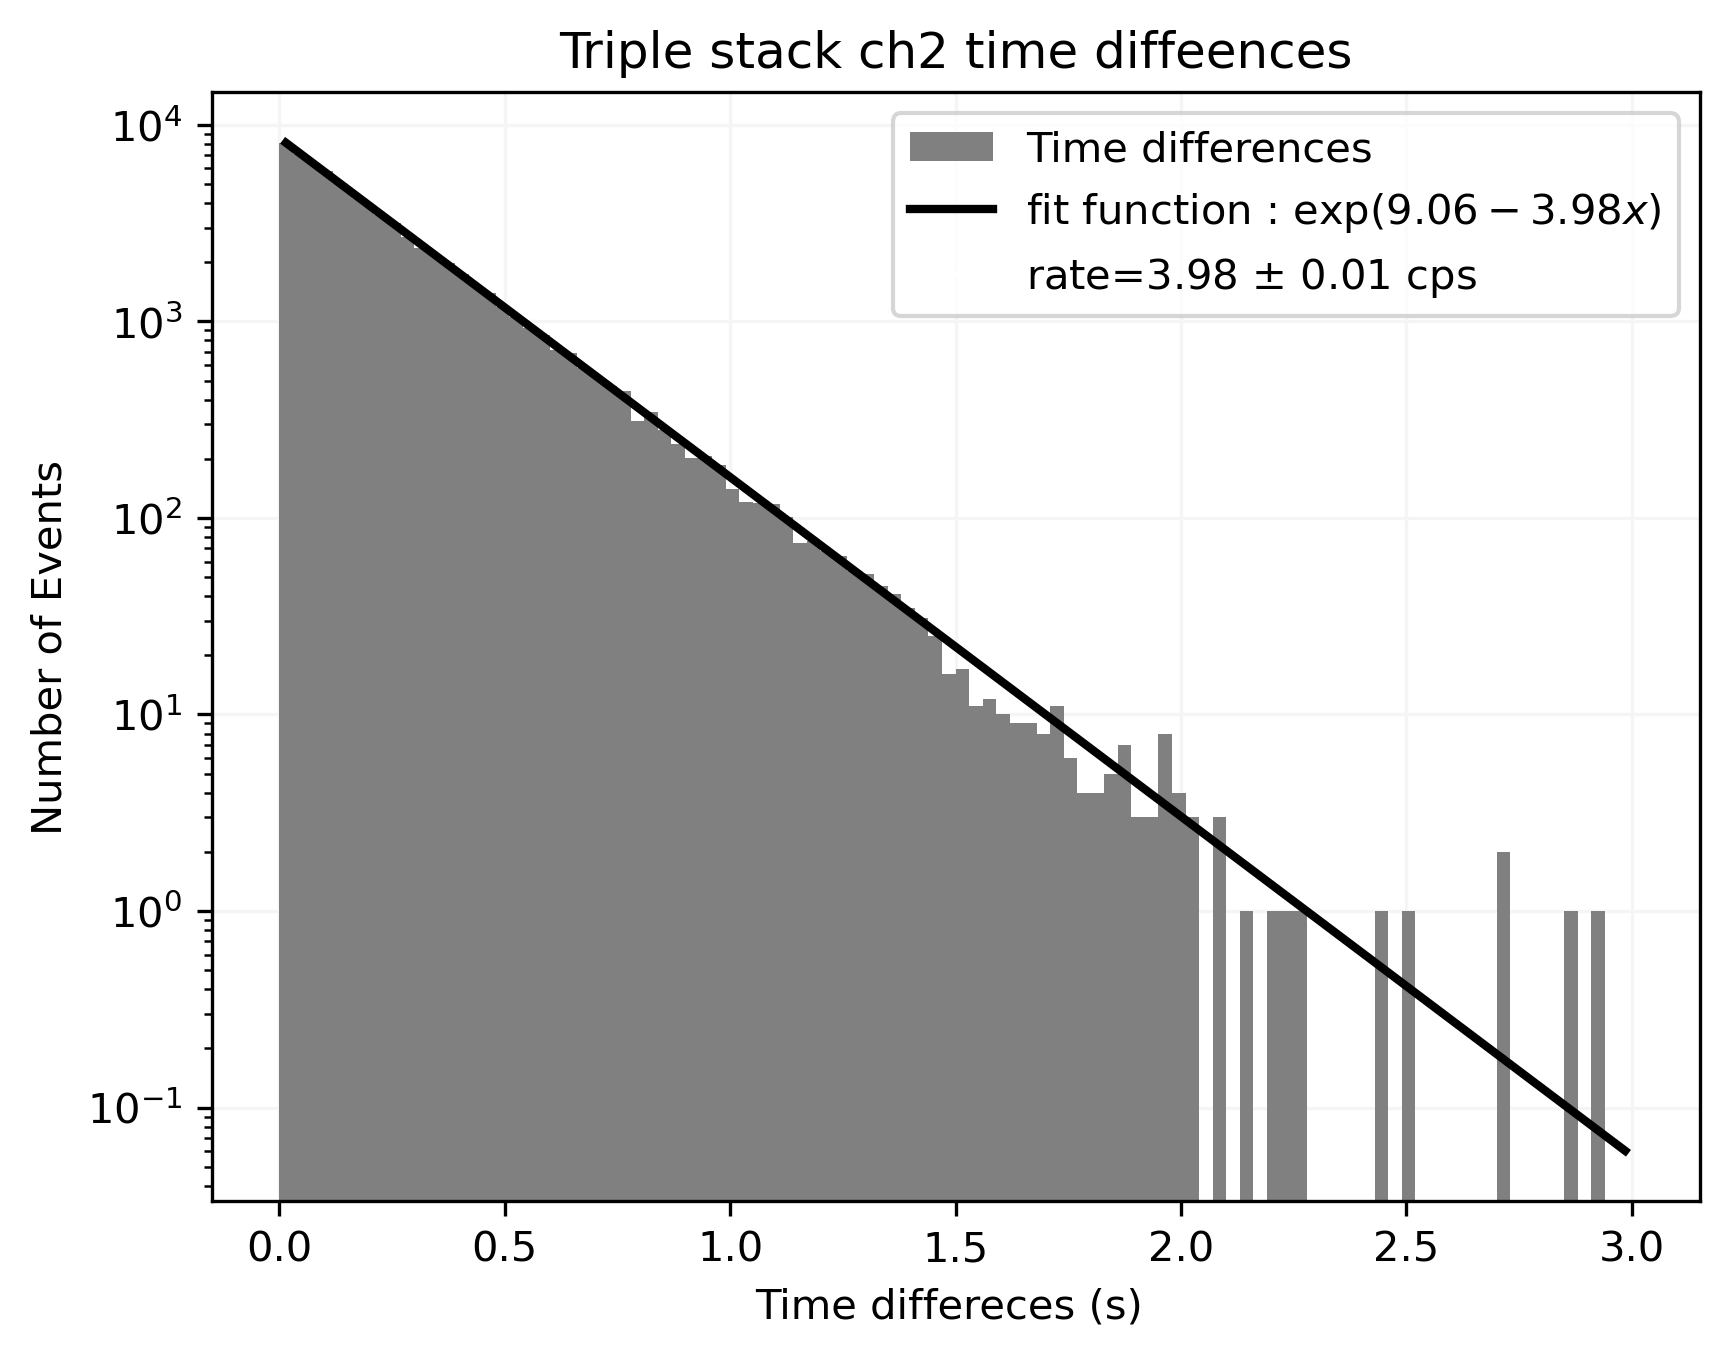

double -4.018144011607759 triple -3.9763593253968015 ratio 0.9896009983489272 error 0.08876004620216901


In [31]:
# now I am going to try and fit the time differences plot with curve_fit

import numpy as np
from scipy.optimize import curve_fit
#firts I define the exponential fucntion that I will be fitting 
def expo(x, a, b):
    return  np.exp(a+(b*x))

#here I caculate the bin centers for the fit               
def bincenters(bins):
    return (bins[1:] + bins[:-1]) / 2

    # define the histogram that I will be fitting to and return the bin contents and the bid edeges    
bin_cont, bin_edges, patches = plt.hist(CH2_time_diff_sec, bins = 100,range=(0,3), histtype='stepfilled' , color ='gray',label ="Time differences")
    
    
    
# here I do the fit a return the fit values     
param3, param_cov3 = curve_fit(expo, bincenters(bin_edges),bin_cont)
                   

      
                   
# print the values     
print("Expo function coefficients:")
print(param3)
print("Covariance of coefficients:")
print(param_cov3)
perr3 = np.sqrt(np.diag(param_cov3))
print ("rate err", perr3[1])


# now I also want to draw the fitted function on top of the histogram 
fit_func= expo(bincenters(bin_edges),param3[0] ,param3[1] )
plt.plot(bincenters(bin_edges), fit_func, 'black', linewidth=2, label ="fit function : exp$({:.2f} {:.2f}x)$".format(param3[0] ,param3[1]))       

#fit_eq= r"exp$({:.2f} {:.2f}x)$".format(param3[0] ,param3[1])

ax=plt.gca()
#ax.text(1, 800, fit_eq, fontsize=15)
#ax.text(2, 100, "rate={:.2f} cps".format(abs(param[1])), fontsize=15)
#ax.text(1.3, 300, "rate={:.2f} $\\pm$ {:.2f} cps".format(abs(param3[1]), perr3[1]), fontsize=15)
ax.plot([],[],label="rate={:.2f} $\\pm$ {:.2f} cps".format(abs(param3[1]), perr3[1]), color='w')
plt.legend()
plt.yscale('log')
ax.set_title("Triple stack ch2 time diffeences")
ax.set_xlabel("Time differeces (s) ")
ax.set_ylabel('Number of Events')
plt.show()

print("double",param[1], "triple",param3[1], "ratio", param3[1]/param[1], "error", np.sqrt(perr3[1]**2+perr[1]))


In [32]:
CH2_timestamps_sec=CH2_timestamps/1e+12
CH2_timestamps_min=CH2_timestamps_sec/60
rate_min_2=np.floor(CH2_timestamps_min)
rate_min_2
#len(rate_min_2)

array([  0.,   0.,   0., ..., 299., 299., 299.])

In [115]:
bins_hist=np.linspace(0,300,301)

mean double 242.63333333333333 mean triple 239.98333333333332


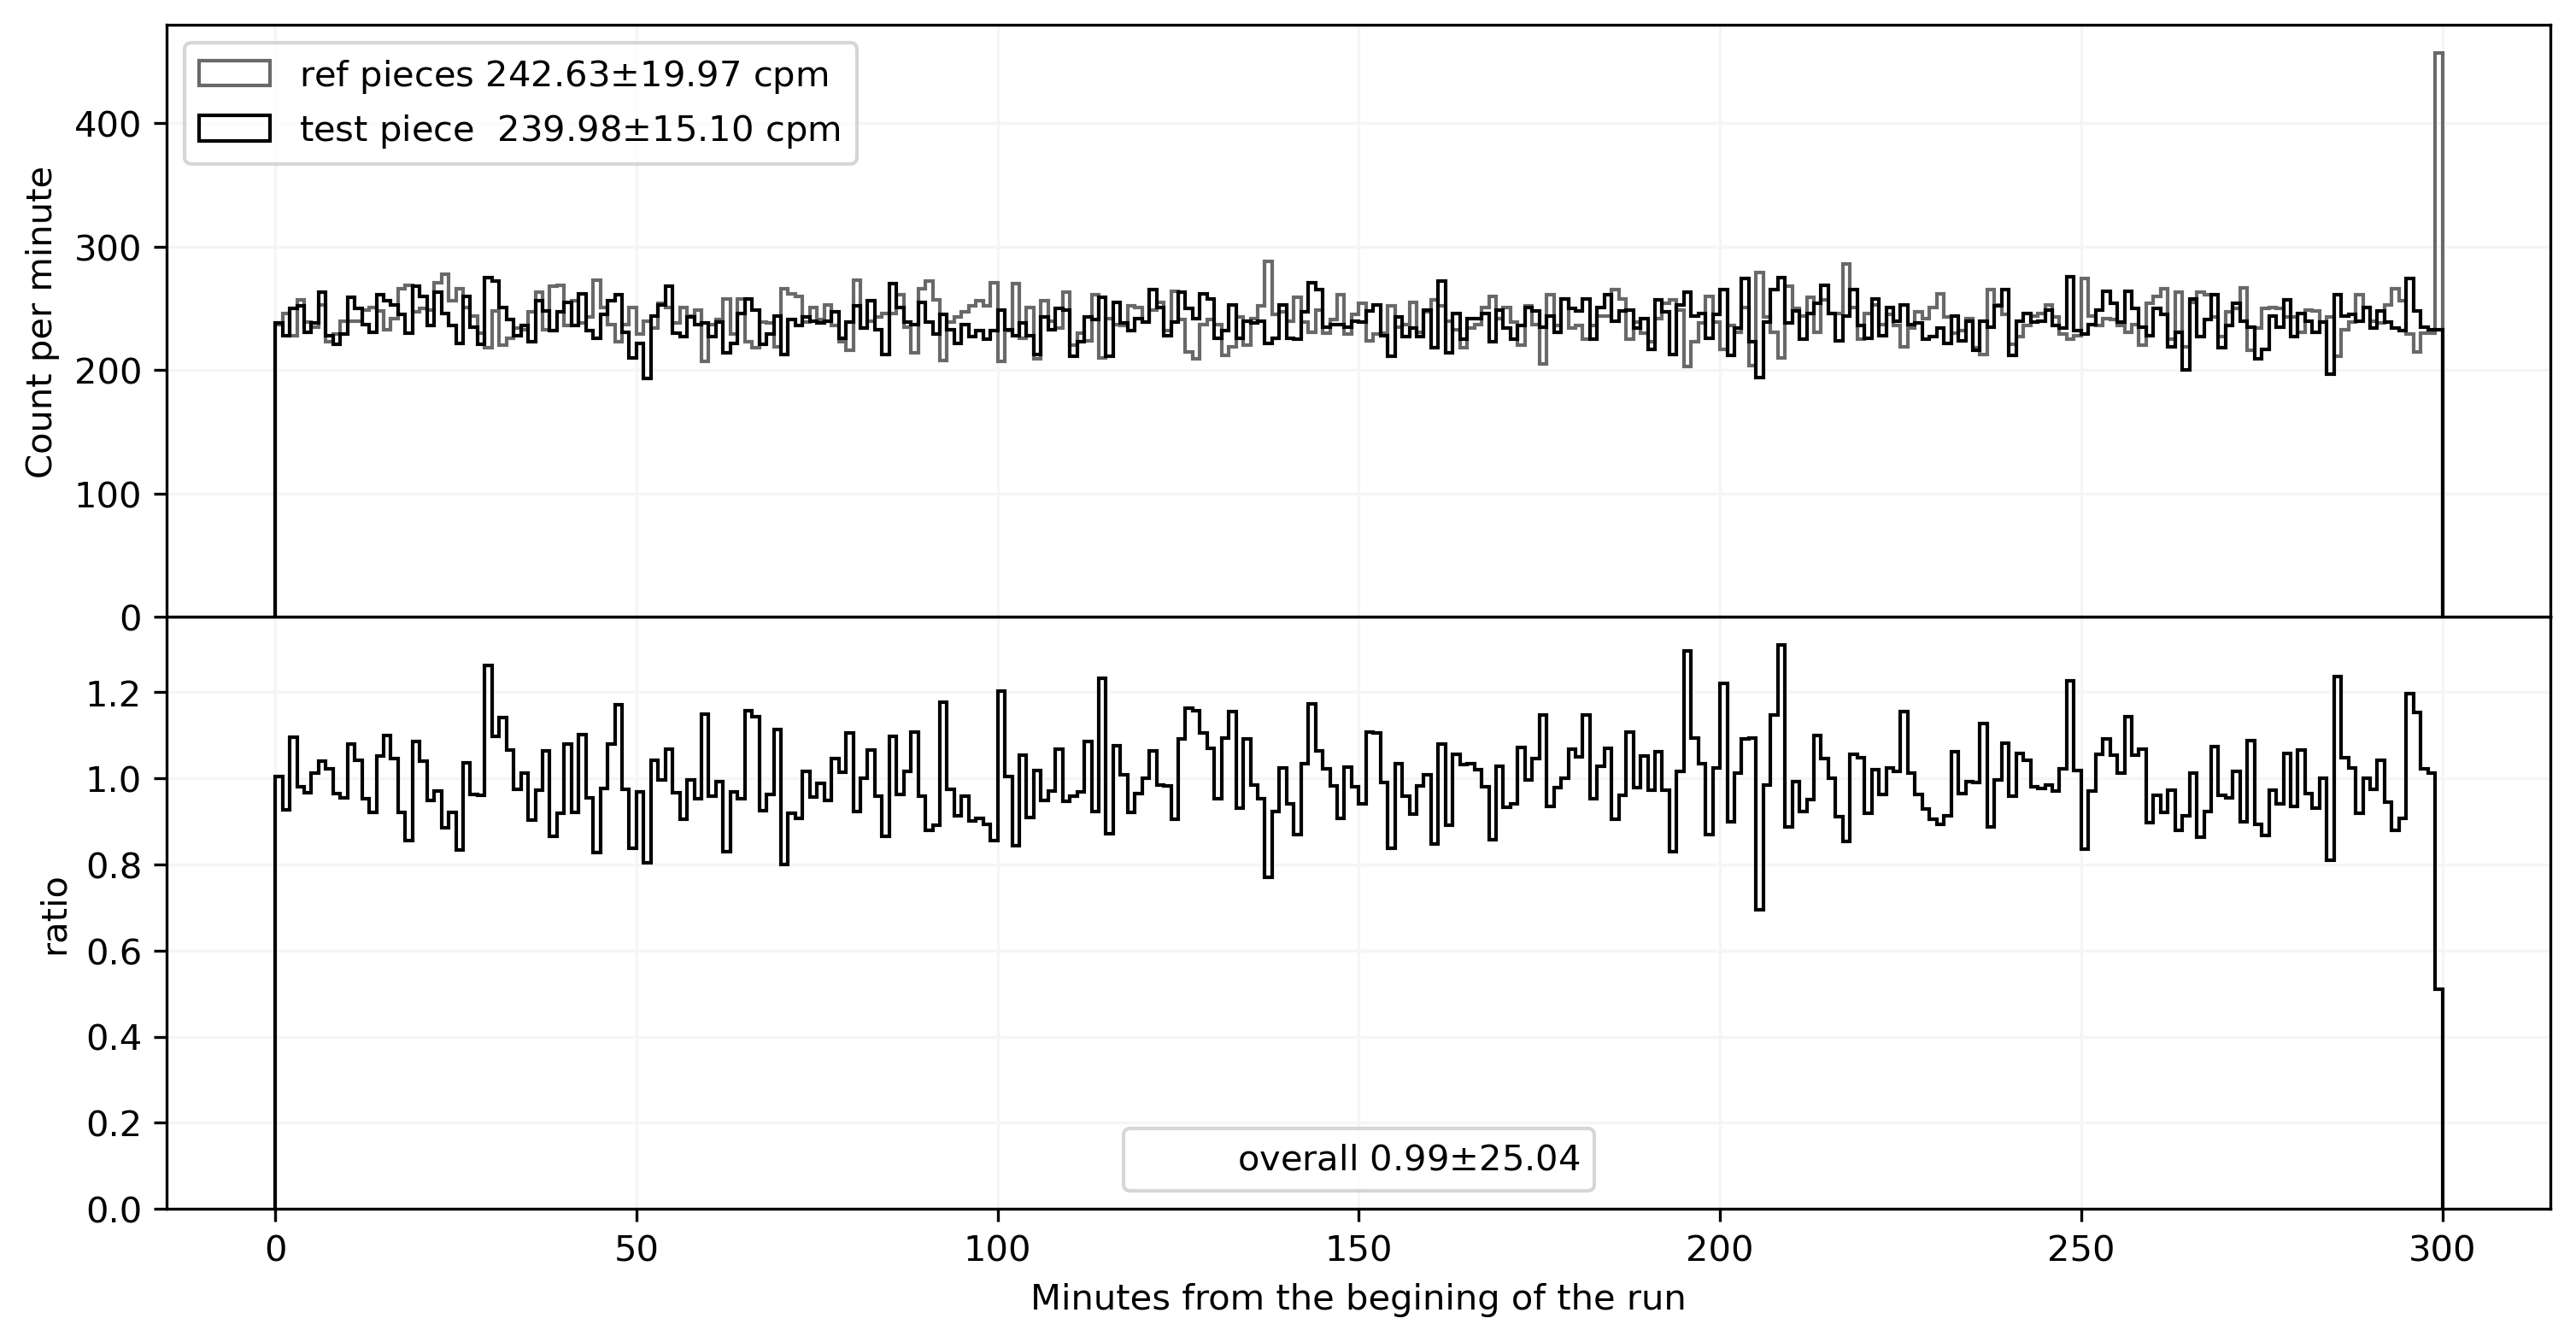

In [116]:

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,figsize=(12,6))
plt.subplots_adjust(hspace=0)
plt.axes(ax[0])
bin_contents, bin_edges, patches =plt.hist(rate_min_0,bins = bins_hist, histtype='step',color='dimgray',label='double stack')
bin_contents3, bin_edges3, patches3 =plt.hist(rate_min_2,bins = bins_hist, histtype='step',color='black',label='test section')
mean=np.mean(bin_contents)
mean3= np.mean(bin_contents3)
err=np.std(bin_contents)
err3=np.std(bin_contents3)

ax[0] = plt.gca()
ax[0].set_ylabel("Count per minute")
#ax[0].set_ylim([150, 300])
#ax[0].set_xlabel("Minutes from the begining of the run")
#plt.title('Section 2 ( not corrected by area differences)')
#ax[0].legend(loc=(0.4, 0.45))
ax[0].legend(labels=["ref pieces %.2f$\\pm$%.2f cpm" % (mean, err), "test piece  %.2f$\\pm$%.2f cpm " % (mean3, err3)])

sec_area_ratio=1.024 # for sec 1

#ax[1].stairs((bin_contents3*sec_area_ratio)/bin_contents,bin_edges,color='black')
ax[1].stairs((bin_contents3)/bin_contents,bin_edges, color='black')
ax[1].set_ylabel('ratio')
ax[1].set_xlabel("Minutes from the begining of the run")
ratio=mean3/mean
rerr=np.sqrt((err3**2)+(err**2))
print("mean double",np.mean(bin_contents),"mean triple", np.mean(bin_contents3))

ax[1].plot([],[],label='overall %.2f$\\pm$%.2f' % (ratio, rerr), color='w')
#ax[1].plot([],[],label='efficiency %.2f' % (ratio), color='w')
ax[1].legend()


plt.show()
#ax[1].set_xlim(min(bins), max(bins))

In [108]:
np.mean(bin_contents)

242.63333333333333

In [109]:
bin_edges

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [85]:
bin_edges3

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

(array([0.006104  , 0.01678599, 0.02308074, 0.00991899, 0.00095375,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00019075]),
 array([203.        , 220.53333333, 238.06666667, 255.6       ,
        273.13333333, 290.66666667, 308.2       , 325.73333333,
        343.26666667, 360.8       , 378.33333333, 395.86666667,
        413.4       , 430.93333333, 448.46666667, 466.        ]),
 <BarContainer object of 15 artists>)

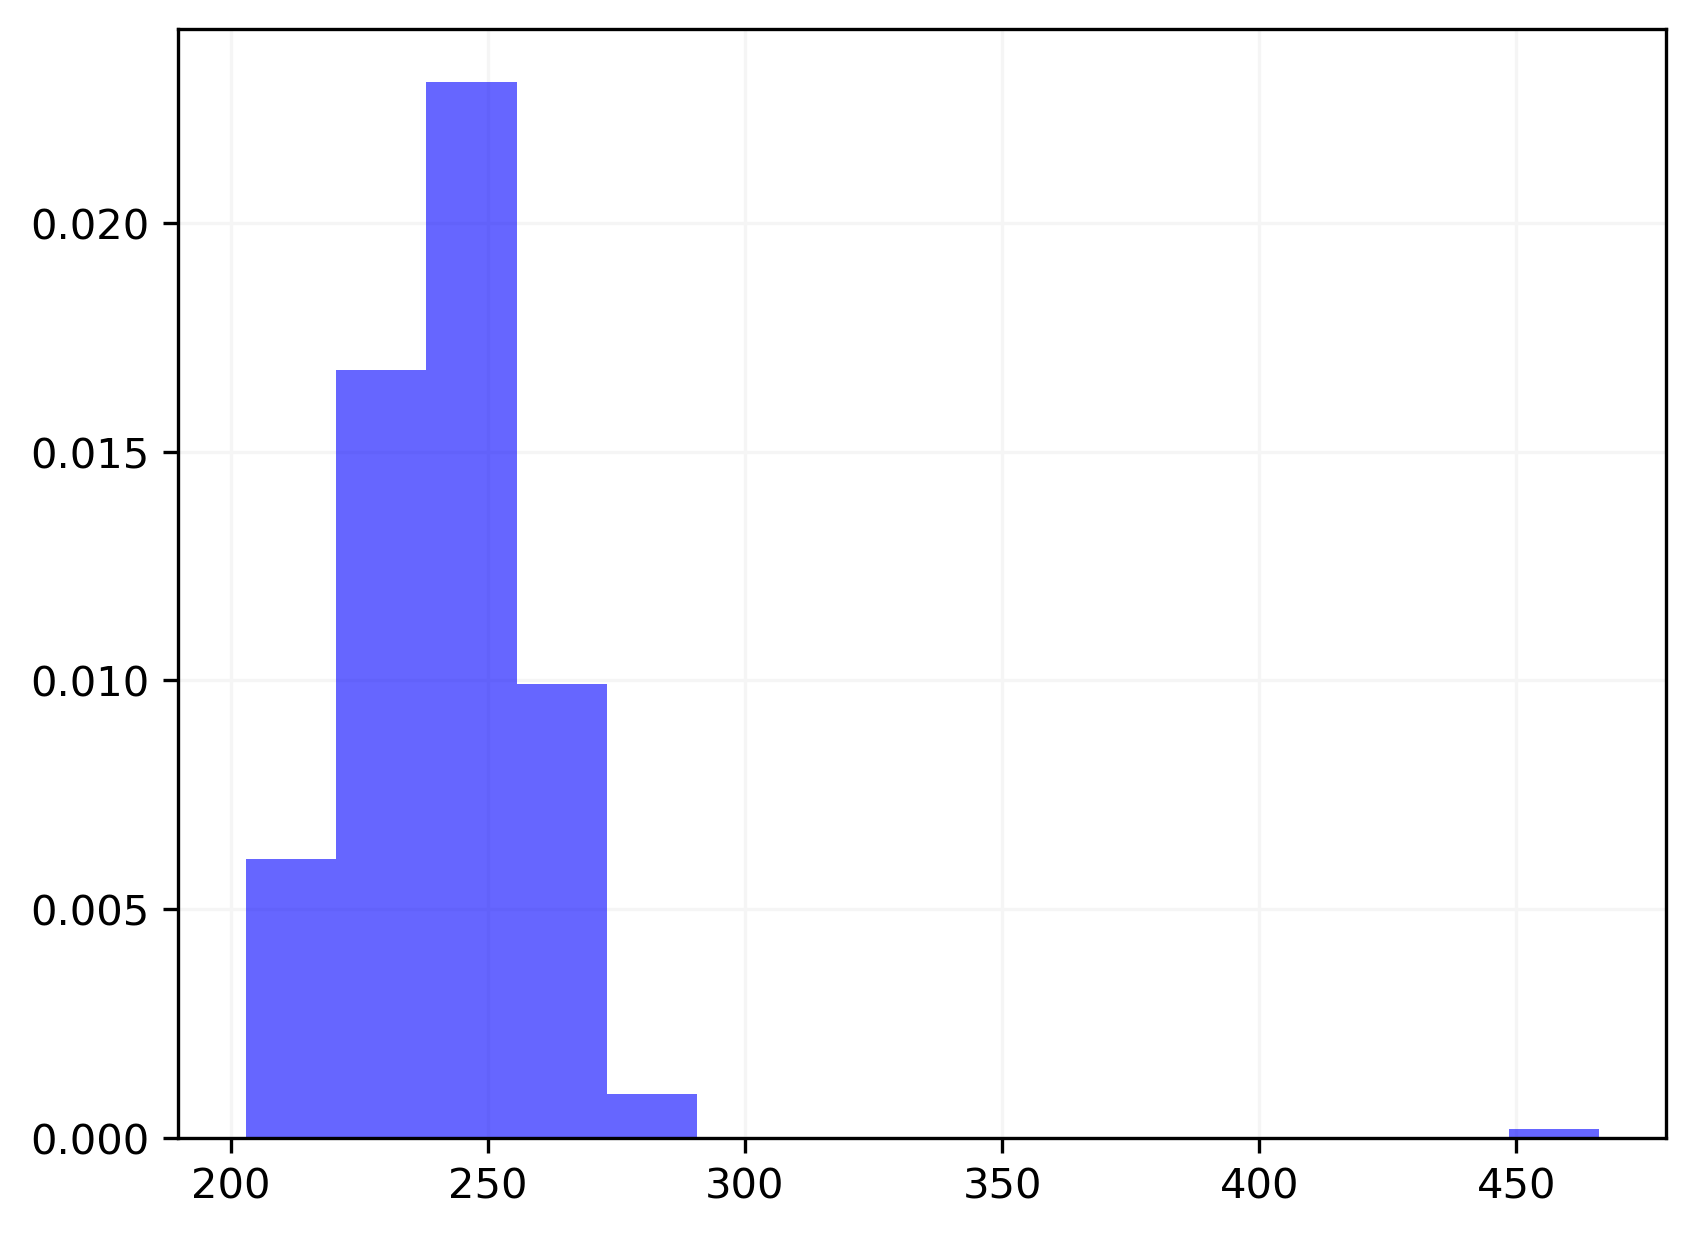

In [37]:
# Plotting the histogram.
plt.hist(bin_contents, bins=15, density=True, alpha=0.6, color='b')
 


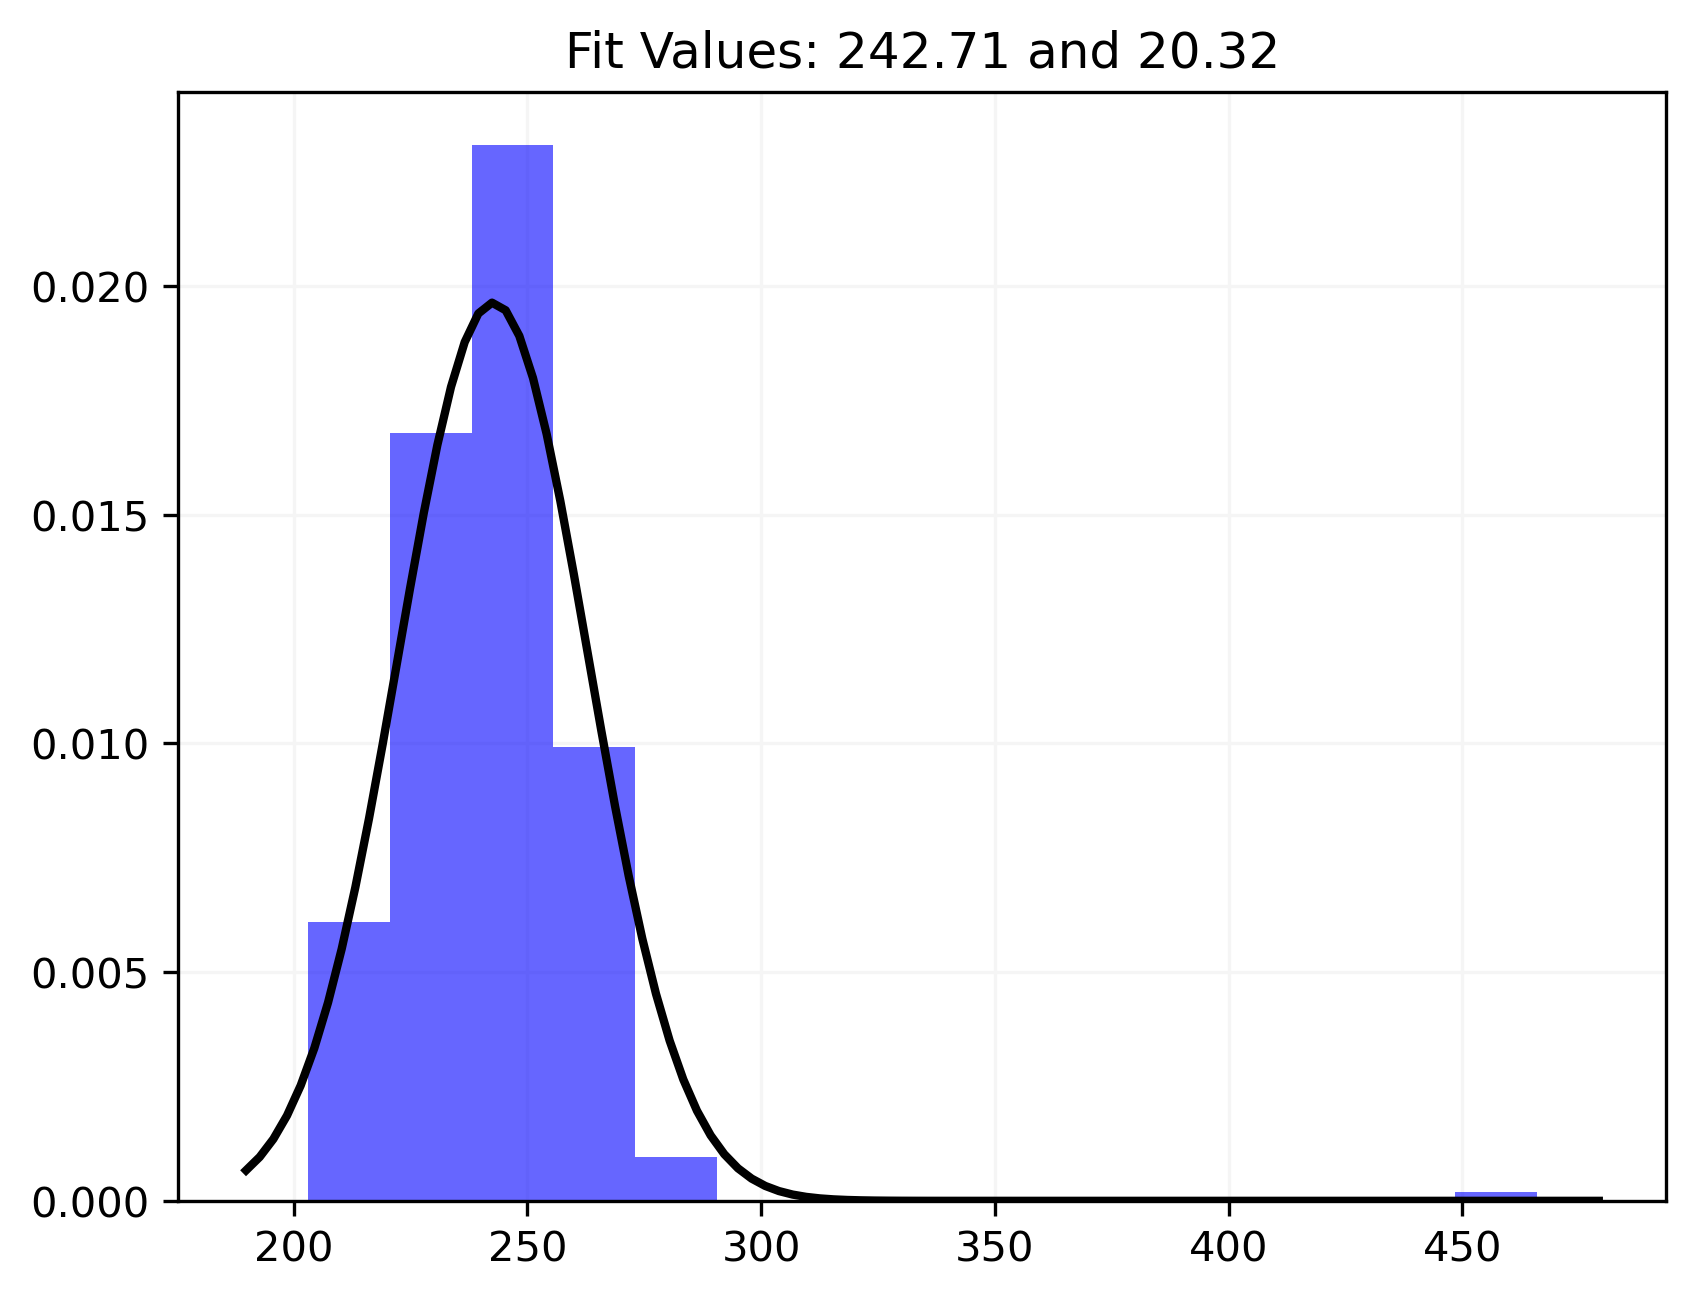

In [38]:
from scipy.stats import norm

# Plotting the histogram.
plt.hist(bin_contents, bins=15, density=True, alpha=0.6, color='b')
 
mu, std = norm.fit(bin_contents) 
 
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
 
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
plt.show()

In [103]:
bins=np.linspace(0,300,301)

In [104]:
bins

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15